In [1]:
library("lme4")
library("ggplot2")
library("dplyr")
library(MASS)
library("BayesFactor")
library("car")
library("scales")
library("lmerTest")
#library("MuMIn")
library("plyr")
library("rstatix")
library("ggpubr")
library("knitr")
library("corrplot")
library("RColorBrewer")
library("svglite")
library("cowplot")

Loading required package: Matrix


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Loading required package: coda

************
Welcome to BayesFactor 0.9.12-4.4. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************

Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode



Attaching package: 'lmerTest'


The following object is masked from 'package:lme4':

    lmer


The following object is masked from 'package:stats':

    step


------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functi

In [2]:
#Load the data => Here, we are filtering the cases in which subjects had a MuIFI of 0
FinalPath<-'./R_Data_ALL.txt'
data <- read.delim(FinalPath, sep="\t", header=T, stringsAsFactors=F)

In [3]:
table(data$Agent, data$GameNb)

                   
                      1   2   3   4   5   6   7   8   9  10  11  12  13  14  15
  Coupled           100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
  Coupled_Strategy   32  32  32  32  32  32  32  32  32  32  32  32  32  32  32
  MS17              100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
  Streamed          100 100 100 100 100 100 100 100 100 100 100 100 100 100 100
  Streamed_Strategy   9   9   9   9   9   9   9   9   9   9   9   9   9   9   9

In [4]:
##Source for "SummarySE": http://www.cookbook-r.com/Manipulating_data/Summarizing_data/
##
##
## Gives count, mean, standard deviation, standard error of the mean, and confidence interval (default 95%).
##   data: a data frame.
##   measurevar: the name of a column that contains the variable to be summariezed
##   groupvars: a vector containing names of columns that contain grouping variables
##   na.rm: a boolean that indicates whether to ignore NA's
##   conf.interval: the percent range of the confidence interval (default is 95%)
summarySE <- function(data=NULL, measurevar, groupvars=NULL, na.rm=FALSE,
                      conf.interval=.95, .drop=TRUE) {
    library(plyr)

    # New version of length which can handle NA's: if na.rm==T, don't count them
    length2 <- function (x, na.rm=FALSE) {
        if (na.rm) sum(!is.na(x))
        else       length(x)
    }

    # This does the summary. For each group's data frame, return a vector with
    # N, mean, and sd
    datac <- ddply(data, groupvars, .drop=.drop,
      .fun = function(xx, col) {
        c(N    = length2(xx[[col]], na.rm=na.rm),
          mean = mean   (xx[[col]], na.rm=na.rm),
          sd   = sd     (xx[[col]], na.rm=na.rm)
        )
      },
      measurevar
    )

    # Rename the "mean" column    
    datac <- rename(datac, c("mean" = measurevar))

    datac$se <- datac$sd / sqrt(datac$N)  # Calculate standard error of the mean

    # Confidence interval multiplier for standard error
    # Calculate t-statistic for confidence interval: 
    # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
    ciMult <- qt(conf.interval/2 + .5, datac$N-1)
    datac$ci <- datac$se * ciMult

    return(datac)
}

In [5]:
# Multiple plot function: source: http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)/
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

# Compute RMSE for fast-shooting data

In [6]:
#RMSE function definition
RMSE = function(mod, obs){
  sqrt(mean((mod - obs)^2))
}

#Filtered data set
fast_data <- data %>% filter(!Agent=='Coupled_Strategy')
head(fast_data,10)

,Agent,subject,GameNb,Deflations,Misses,Resets,ShotReg,Entropy,LogCV,ShotPer,RightReg,Score
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Coupled,model_6592528450_1,1,96,63,3,0.2749406,2.938219,-0.9013436,480,0.1648576,256
2,Coupled,model_6592528450_1,2,22,107,2,0.4118143,2.848877,-1.3099846,512,0.3605711,888
3,Coupled,model_6592528450_1,3,15,57,0,0.4774791,2.329245,-1.7767653,496,0.5570642,1486
4,Coupled,model_6592528450_1,4,12,42,0,0.5218977,2.325269,-1.4100751,496,0.4901174,1718
5,Coupled,model_6592528450_1,5,15,46,2,0.5070372,2.358500,-1.3223362,496,0.5357312,1508
6,Coupled,model_6592528450_1,6,20,51,0,0.4869756,2.249658,-1.4796068,496,0.5706765,1198
7,Coupled,model_6592528450_1,7,19,63,0,0.4852614,2.230736,-1.8959978,496,0.5582201,1174
8,Coupled,model_6592528450_1,8,16,52,1,0.4792956,2.216584,-1.3405258,496,0.5472919,1398
9,Coupled,model_6592528450_1,9,9,23,1,0.4849891,1.970430,-1.5390336,496,0.5619010,1872


In [7]:
#1) Performance results
muTab<-aggregate(fast_data$Score, by=list(fast_data$Agent,fast_data$GameNb), FUN=mean)
colnames(muTab)<-c("Agent","GameNb","Score")
H_vec <- c(1:15)
for (i in 1:15)
{
    H_vec[i] <- muTab[which(muTab$Agent=="Streamed_Strategy" & muTab$GameNb==i),]$Score
}
M_vec <- c(1:15)
for (i in 1:15)
{
    M_vec[i] <- muTab[which(muTab$Agent=="Streamed" & muTab$GameNb==i),]$Score
}

#correlations & RMSE per condition
#print("Performance correlations & RMSE")
r_perf <- cor(H_vec,M_vec,method = "pearson")
rmse_perf <- RMSE(M_vec,H_vec)
r_perf
rmse_perf

print("MS17 comparison")
M2_vec <- c(1:15)
for (i in 1:15)
{
    M2_vec[i] <- muTab[which(muTab$Agent=="MS17" & muTab$GameNb==i),]$Score
}

r2_perf <- cor(H_vec,M2_vec,method = "pearson")
rmse2_perf <- RMSE(M2_vec,H_vec)
r2_perf
rmse2_perf

print("Blending comparison")
M3_vec <- c(1:15)
for (i in 1:15)
{
    M3_vec[i] <- muTab[which(muTab$Agent=="Coupled" & muTab$GameNb==i),]$Score
}

r3_perf <- cor(H_vec,M3_vec,method = "pearson")
rmse3_perf <- RMSE(M3_vec,H_vec)
r3_perf
rmse3_perf

[1] 0.9828553

[1] 92.56974

[1] "MS17 comparison"


[1] 0.8904402

[1] 1428.209

[1] "Blending comparison"


[1] 0.9736249

[1] 1059.558

In [9]:
#2) Entropy
fast_data <- data %>% filter(!Agent=='Coupled_Strategy')
fast_data <- fast_data %>% filter(!Entropy=='NaN')
muTab<-aggregate(fast_data$Entropy, by=list(fast_data$Agent,fast_data$GameNb), FUN=mean)

colnames(muTab)<-c("Agent","GameNb","Entropy")
H_vec <- c(1:15)
for (i in 1:15)
{
    H_vec[i] <- muTab[which(muTab$Agent=="Streamed_Strategy" & muTab$GameNb==i),]$Entropy
}
M_vec <- c(1:15)
for (i in 1:15)
{
    M_vec[i] <- muTab[which(muTab$Agent=="Streamed" & muTab$GameNb==i),]$Entropy
}

#correlations & RMSE per condition
#print("Performance correlations & RMSE")
r_ent <- cor(H_vec,M_vec,method = "pearson")
rmse_ent <- RMSE(M_vec,H_vec)
r_ent
rmse_ent

print("MS17 comparison")
M2_vec <- c(1:15)
for (i in 1:15)
{
    M2_vec[i] <- muTab[which(muTab$Agent=="MS17" & muTab$GameNb==i),]$Entropy
}

r2_ent <- cor(H_vec,M2_vec,method = "pearson")
rmse2_ent <- RMSE(M2_vec,H_vec)
r2_ent
rmse2_ent

print("Blending comparison")
M3_vec <- c(1:15)
for (i in 1:15)
{
    M3_vec[i] <- muTab[which(muTab$Agent=="Coupled" & muTab$GameNb==i),]$Entropy
}

r3_ent <- cor(H_vec,M3_vec,method = "pearson")
rmse3_ent <- RMSE(M3_vec,H_vec)
r3_ent
rmse3_ent

[1] 0.913891

[1] 0.04846186

[1] "MS17 comparison"


[1] 0.07290119

[1] 0.3395394

[1] "Blending comparison"


[1] 0.7622802

[1] 0.1681341

In [10]:
#3) Log CV ISI
fast_data <- data %>% filter(!Agent=='Coupled_Strategy')
fast_data <- fast_data %>% filter(!LogCV=='NaN')
muTab<-aggregate(fast_data$LogCV, by=list(fast_data$Agent,fast_data$GameNb), FUN=mean)

colnames(muTab)<-c("Agent","GameNb","LogCV")
H_vec <- c(1:15)
for (i in 1:15)
{
    H_vec[i] <- muTab[which(muTab$Agent=="Streamed_Strategy" & muTab$GameNb==i),]$LogCV
}
M_vec <- c(1:15)
for (i in 1:15)
{
    M_vec[i] <- muTab[which(muTab$Agent=="Streamed" & muTab$GameNb==i),]$LogCV
}

#correlations & RMSE per condition
#print("Performance correlations & RMSE")
r_lcv <- cor(H_vec,M_vec,method = "pearson")
rmse_lcv <- RMSE(M_vec,H_vec)
r_lcv
rmse_lcv

print("MS17 comparison")
M2_vec <- c(1:15)
for (i in 1:15)
{
    M2_vec[i] <- muTab[which(muTab$Agent=="MS17" & muTab$GameNb==i),]$LogCV
}

r2_lcv <- cor(H_vec,M2_vec,method = "pearson")
rmse2_lcv <- RMSE(M2_vec,H_vec)
r2_lcv
rmse2_lcv

print("Blending comparison")
M3_vec <- c(1:15)
for (i in 1:15)
{
    M3_vec[i] <- muTab[which(muTab$Agent=="Coupled" & muTab$GameNb==i),]$LogCV
}

r3_lcv <- cor(H_vec,M3_vec,method = "pearson")
rmse3_lcv <- RMSE(M3_vec,H_vec)
r3_lcv
rmse3_lcv

[1] 0.9458186

[1] 0.1084891

[1] "MS17 comparison"


[1] -0.9104553

[1] 0.525365

[1] "Blending comparison"


[1] 0.778844

[1] 0.1501743

In [11]:
#4) Resets
fast_data <- data %>% filter(!Agent=='Coupled_Strategy')
#fast_data <- fast_data %>% filter(!LogCV=='NaN')
muTab<-aggregate(fast_data$Resets, by=list(fast_data$Agent,fast_data$GameNb), FUN=mean)

colnames(muTab)<-c("Agent","GameNb","Resets")
H_vec <- c(1:15)
for (i in 1:15)
{
    H_vec[i] <- muTab[which(muTab$Agent=="Streamed_Strategy" & muTab$GameNb==i),]$Resets
}
M_vec <- c(1:15)
for (i in 1:15)
{
    M_vec[i] <- muTab[which(muTab$Agent=="Streamed" & muTab$GameNb==i),]$Resets
}

#correlations & RMSE per condition
r_res <- cor(H_vec,M_vec,method = "pearson")
rmse_res <- RMSE(M_vec,H_vec)
r_res
rmse_res

print("MS17 comparison")
M2_vec <- c(1:15)
for (i in 1:15)
{
    M2_vec[i] <- muTab[which(muTab$Agent=="MS17" & muTab$GameNb==i),]$Resets
}

r2_res <- cor(H_vec,M2_vec,method = "pearson")
rmse2_res <- RMSE(M2_vec,H_vec)
r2_res
rmse2_res

print("Blending comparison")
M3_vec <- c(1:15)
for (i in 1:15)
{
    M3_vec[i] <- muTab[which(muTab$Agent=="Coupled" & muTab$GameNb==i),]$Resets
}

r3_res <- cor(H_vec,M3_vec,method = "pearson")
rmse3_res <- RMSE(M3_vec,H_vec)
r3_res
rmse3_res

[1] 0.5662461

[1] 3.968592

[1] "MS17 comparison"


[1] -0.834857

[1] 9.881736

[1] "Blending comparison"


[1] 0.6190385

[1] 6.067276

In [12]:
#5) Deflations
fast_data <- data %>% filter(!Agent=='Coupled_Strategy')
#fast_data <- fast_data %>% filter(!LogCV=='NaN')
muTab<-aggregate(fast_data$Deflations, by=list(fast_data$Agent,fast_data$GameNb), FUN=mean)

colnames(muTab)<-c("Agent","GameNb","Deflations")
H_vec <- c(1:15)
for (i in 1:15)
{
    H_vec[i] <- muTab[which(muTab$Agent=="Streamed_Strategy" & muTab$GameNb==i),]$Deflations
}
M_vec <- c(1:15)
for (i in 1:15)
{
    M_vec[i] <- muTab[which(muTab$Agent=="Streamed" & muTab$GameNb==i),]$Deflations
}

#correlations & RMSE per condition
r_def <- cor(H_vec,M_vec,method = "pearson")
rmse_def <- RMSE(M_vec,H_vec)
r_def
rmse_def

print("MS17 comparison")
M2_vec <- c(1:15)
for (i in 1:15)
{
    M2_vec[i] <- muTab[which(muTab$Agent=="MS17" & muTab$GameNb==i),]$Deflations
}

r2_def <- cor(H_vec,M2_vec,method = "pearson")
rmse2_def <- RMSE(M2_vec,H_vec)
r2_def
rmse2_def

print("Blending comparison")
M3_vec <- c(1:15)
for (i in 1:15)
{
    M3_vec[i] <- muTab[which(muTab$Agent=="Coupled" & muTab$GameNb==i),]$Deflations
}

r3_def <- cor(H_vec,M3_vec,method = "pearson")
rmse3_def <- RMSE(M3_vec,H_vec)
r3_def
rmse3_def

[1] 0.9418318

[1] 7.765479

[1] "MS17 comparison"


[1] 0.9336207

[1] 39.86477

[1] "Blending comparison"


[1] 0.8963364

[1] 20.50094

In [13]:
#6) Misses
fast_data <- data %>% filter(!Agent=='Coupled_Strategy')
#fast_data <- fast_data %>% filter(!LogCV=='NaN')
muTab<-aggregate(fast_data$Misses, by=list(fast_data$Agent,fast_data$GameNb), FUN=mean)

colnames(muTab)<-c("Agent","GameNb","Misses")
H_vec <- c(1:15)
for (i in 1:15)
{
    H_vec[i] <- muTab[which(muTab$Agent=="Streamed_Strategy" & muTab$GameNb==i),]$Misses
}
M_vec <- c(1:15)
for (i in 1:15)
{
    M_vec[i] <- muTab[which(muTab$Agent=="Streamed" & muTab$GameNb==i),]$Misses
}

#correlations & RMSE per condition
r_mis <- cor(H_vec,M_vec,method = "pearson")
rmse_mis <- RMSE(M_vec,H_vec)
r_mis
rmse_mis

print("MS17 comparison")
M2_vec <- c(1:15)
for (i in 1:15)
{
    M2_vec[i] <- muTab[which(muTab$Agent=="MS17" & muTab$GameNb==i),]$Misses
}

r2_mis <- cor(H_vec,M2_vec,method = "pearson")
rmse2_mis <- RMSE(M2_vec,H_vec)
r2_mis
rmse2_mis

print("Blending comparison")
M3_vec <- c(1:15)
for (i in 1:15)
{
    M3_vec[i] <- muTab[which(muTab$Agent=="Coupled" & muTab$GameNb==i),]$Misses
}

r3_mis <- cor(H_vec,M3_vec,method = "pearson")
rmse3_mis <- RMSE(M3_vec,H_vec)
r3_mis
rmse3_mis

[1] 0.9311873

[1] 11.63029

[1] "MS17 comparison"


[1] 0.9570341

[1] 21.15095

[1] "Blending comparison"


[1] 0.602747

[1] 16.55911

In [14]:
#7) Shot periodicity
fast_data <- data %>% filter(!Agent=='Coupled_Strategy')
fast_data <- fast_data %>% filter(!ShotPer=='NaN')
muTab<-aggregate(fast_data$ShotPer, by=list(fast_data$Agent,fast_data$GameNb), FUN=mean)

colnames(muTab)<-c("Agent","GameNb","ShotPer")
H_vec <- c(1:15)
for (i in 1:15)
{
    H_vec[i] <- muTab[which(muTab$Agent=="Streamed_Strategy" & muTab$GameNb==i),]$ShotPer
}
M_vec <- c(1:15)
for (i in 1:15)
{
    M_vec[i] <- muTab[which(muTab$Agent=="Streamed" & muTab$GameNb==i),]$ShotPer
}

#correlations & RMSE per condition
r_per <- cor(H_vec,M_vec,method = "pearson")
rmse_per <- RMSE(M_vec,H_vec)
r_per
rmse_per

print("MS17 comparison")
M2_vec <- c(1:15)
for (i in 1:15)
{
    M2_vec[i] <- muTab[which(muTab$Agent=="MS17" & muTab$GameNb==i),]$ShotPer
}

r2_per <- cor(H_vec,M2_vec,method = "pearson")
rmse2_per <- RMSE(M2_vec,H_vec)
r2_per
rmse2_per

print("Blending comparison")
M3_vec <- c(1:15)
for (i in 1:15)
{
    M3_vec[i] <- muTab[which(muTab$Agent=="Coupled" & muTab$GameNb==i),]$ShotPer
}

r3_per <- cor(H_vec,M3_vec,method = "pearson")
rmse3_per <- RMSE(M3_vec,H_vec)
r3_per
rmse3_per

[1] 0.6692808

[1] 27.42225

[1] "MS17 comparison"


[1] 0.8458051

[1] 40.36075

[1] "Blending comparison"


[1] -0.1147442

[1] 102.6939

In [15]:
#8) Shot regularity
fast_data <- data %>% filter(!Agent=='Coupled_Strategy')
fast_data <- fast_data %>% filter(!ShotReg=='NaN')
muTab<-aggregate(fast_data$ShotReg, by=list(fast_data$Agent,fast_data$GameNb), FUN=mean)

colnames(muTab)<-c("Agent","GameNb","ShotReg")
H_vec <- c(1:15)
for (i in 1:15)
{
    H_vec[i] <- muTab[which(muTab$Agent=="Streamed_Strategy" & muTab$GameNb==i),]$ShotReg
}
M_vec <- c(1:15)
for (i in 1:15)
{
    M_vec[i] <- muTab[which(muTab$Agent=="Streamed" & muTab$GameNb==i),]$ShotReg
}

#correlations & RMSE per condition
r_reg <- cor(H_vec,M_vec,method = "pearson")
rmse_reg <- RMSE(M_vec,H_vec)
r_reg
rmse_reg

print("MS17 comparison")
M2_vec <- c(1:15)
for (i in 1:15)
{
    M2_vec[i] <- muTab[which(muTab$Agent=="MS17" & muTab$GameNb==i),]$ShotReg
}

r2_reg <- cor(H_vec,M2_vec,method = "pearson")
rmse2_reg <- RMSE(M2_vec,H_vec)
r2_reg
rmse2_reg

print("Blending comparison")
M3_vec <- c(1:15)
for (i in 1:15)
{
    M3_vec[i] <- muTab[which(muTab$Agent=="Coupled" & muTab$GameNb==i),]$ShotReg
}

r3_reg <- cor(H_vec,M3_vec,method = "pearson")
rmse3_reg <- RMSE(M3_vec,H_vec)
r3_reg
rmse3_reg

[1] 0.6709717

[1] 0.05583908

[1] "MS17 comparison"


[1] 0.03768298

[1] 0.225339

[1] "Blending comparison"


[1] 0.637176

[1] 0.04879694

In [16]:
#9) Right regularity
fast_data <- data %>% filter(!Agent=='Coupled_Strategy')
fast_data <- fast_data %>% filter(!RightReg=='NaN')
muTab<-aggregate(fast_data$RightReg, by=list(fast_data$Agent,fast_data$GameNb), FUN=mean)

colnames(muTab)<-c("Agent","GameNb","RightReg")
H_vec <- c(1:15)
for (i in 1:15)
{
    H_vec[i] <- muTab[which(muTab$Agent=="Streamed_Strategy" & muTab$GameNb==i),]$RightReg
}
M_vec <- c(1:15)
for (i in 1:15)
{
    M_vec[i] <- muTab[which(muTab$Agent=="Streamed" & muTab$GameNb==i),]$RightReg
}

#correlations & RMSE per condition
r_Rreg <- cor(H_vec,M_vec,method = "pearson")
rmse_Rreg <- RMSE(M_vec,H_vec)
r_Rreg
rmse_Rreg

print("MS17 comparison")
M2_vec <- c(1:15)
for (i in 1:15)
{
    M2_vec[i] <- muTab[which(muTab$Agent=="MS17" & muTab$GameNb==i),]$RightReg
}

r2_Rreg <- cor(H_vec,M2_vec,method = "pearson")
rmse2_Rreg <- RMSE(M2_vec,H_vec)
r2_Rreg
rmse2_Rreg

print("Blending comparison")
M3_vec <- c(1:15)
for (i in 1:15)
{
    M3_vec[i] <- muTab[which(muTab$Agent=="Coupled" & muTab$GameNb==i),]$RightReg
}

r3_Rreg <- cor(H_vec,M3_vec,method = "pearson")
rmse3_Rreg <- RMSE(M3_vec,H_vec)
r3_Rreg
rmse3_Rreg

[1] -0.1556053

[1] 0.02100786

[1] "MS17 comparison"


[1] 0.4241586

[1] 0.03576531

[1] "Blending comparison"


[1] -0.4604961

[1] 0.2374127

# Compute RMSE for slow-shooting data

In [17]:
#RMSE function definition
RMSE = function(mod, obs){
  sqrt(mean((mod - obs)^2))
}

#Filtered data set
slow_data <- data %>% filter(!Agent=='Streamed_Strategy')
head(slow_data,10)

,Agent,subject,GameNb,Deflations,Misses,Resets,ShotReg,Entropy,LogCV,ShotPer,RightReg,Score
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Coupled,model_6592528450_1,1,96,63,3,0.2749406,2.938219,-0.9013436,480,0.1648576,256
2,Coupled,model_6592528450_1,2,22,107,2,0.4118143,2.848877,-1.3099846,512,0.3605711,888
3,Coupled,model_6592528450_1,3,15,57,0,0.4774791,2.329245,-1.7767653,496,0.5570642,1486
4,Coupled,model_6592528450_1,4,12,42,0,0.5218977,2.325269,-1.4100751,496,0.4901174,1718
5,Coupled,model_6592528450_1,5,15,46,2,0.5070372,2.358500,-1.3223362,496,0.5357312,1508
6,Coupled,model_6592528450_1,6,20,51,0,0.4869756,2.249658,-1.4796068,496,0.5706765,1198
7,Coupled,model_6592528450_1,7,19,63,0,0.4852614,2.230736,-1.8959978,496,0.5582201,1174
8,Coupled,model_6592528450_1,8,16,52,1,0.4792956,2.216584,-1.3405258,496,0.5472919,1398
9,Coupled,model_6592528450_1,9,9,23,1,0.4849891,1.970430,-1.5390336,496,0.5619010,1872


In [18]:
#1) Performance results
muTab<-aggregate(slow_data$Score, by=list(slow_data$Agent,slow_data$GameNb), FUN=mean)
colnames(muTab)<-c("Agent","GameNb","Score")
H_vec <- c(1:15)
for (i in 1:15)
{
    H_vec[i] <- muTab[which(muTab$Agent=="Coupled_Strategy" & muTab$GameNb==i),]$Score
}
M_vec <- c(1:15)
for (i in 1:15)
{
    M_vec[i] <- muTab[which(muTab$Agent=="Coupled" & muTab$GameNb==i),]$Score
}

#correlations & RMSE per condition
r_perf <- cor(H_vec,M_vec,method = "pearson")
rmse_perf <- RMSE(M_vec,H_vec)
r_perf
rmse_perf

print("MS17 comparison")
M2_vec <- c(1:15)
for (i in 1:15)
{
    M2_vec[i] <- muTab[which(muTab$Agent=="MS17" & muTab$GameNb==i),]$Score
}

r2_perf <- cor(H_vec,M2_vec,method = "pearson")
rmse2_perf <- RMSE(M2_vec,H_vec)
r2_perf
rmse2_perf

print("Hybrid comparison")
M3_vec <- c(1:15)
for (i in 1:15)
{
    M3_vec[i] <- muTab[which(muTab$Agent=="Streamed" & muTab$GameNb==i),]$Score
}

r3_perf <- cor(H_vec,M3_vec,method = "pearson")
rmse3_perf <- RMSE(M3_vec,H_vec)
r3_perf
rmse3_perf

[1] 0.9706117

[1] 131.2162

[1] "MS17 comparison"


[1] 0.9735868

[1] 283.591

[1] "Hybrid comparison"


[1] 0.8874133

[1] 1194.176

In [19]:
#2) Entropy
slow_data <- data %>% filter(!Agent=='Streamed_Strategy')
slow_data <- slow_data %>% filter(!Entropy=='NaN')
muTab<-aggregate(slow_data$Entropy, by=list(slow_data$Agent,slow_data$GameNb), FUN=mean)

colnames(muTab)<-c("Agent","GameNb","Entropy")
H_vec <- c(1:15)
for (i in 1:15)
{
    H_vec[i] <- muTab[which(muTab$Agent=="Coupled_Strategy" & muTab$GameNb==i),]$Entropy
}
M_vec <- c(1:15)
for (i in 1:15)
{
    M_vec[i] <- muTab[which(muTab$Agent=="Coupled" & muTab$GameNb==i),]$Entropy
}

#correlations & RMSE per condition
r_ent <- cor(H_vec,M_vec,method = "pearson")
rmse_ent <- RMSE(M_vec,H_vec)
r_ent
rmse_ent

print("MS17 comparison")
M2_vec <- c(1:15)
for (i in 1:15)
{
    M2_vec[i] <- muTab[which(muTab$Agent=="MS17" & muTab$GameNb==i),]$Entropy
}

r2_ent <- cor(H_vec,M2_vec,method = "pearson")
rmse2_ent <- RMSE(M2_vec,H_vec)
r2_ent
rmse2_ent

print("Hybrid comparison")
M3_vec <- c(1:15)
for (i in 1:15)
{
    M3_vec[i] <- muTab[which(muTab$Agent=="Streamed" & muTab$GameNb==i),]$Entropy
}

r3_ent <- cor(H_vec,M3_vec,method = "pearson")
rmse3_ent <- RMSE(M3_vec,H_vec)
r3_ent
rmse3_ent

[1] 0.9285181

[1] 0.1878632

[1] "MS17 comparison"


[1] 0.5206588

[1] 0.2952622

[1] "Hybrid comparison"


[1] 0.5771378

[1] 0.1014097

In [20]:
#3) Log CV ISI
slow_data <- data %>% filter(!Agent=='Streamed_Strategy')
slow_data <- slow_data %>% filter(!LogCV=='NaN')
muTab<-aggregate(slow_data$LogCV, by=list(slow_data$Agent,slow_data$GameNb), FUN=mean)

colnames(muTab)<-c("Agent","GameNb","LogCV")
H_vec <- c(1:15)
for (i in 1:15)
{
    H_vec[i] <- muTab[which(muTab$Agent=="Coupled_Strategy" & muTab$GameNb==i),]$LogCV
}
M_vec <- c(1:15)
for (i in 1:15)
{
    M_vec[i] <- muTab[which(muTab$Agent=="Coupled" & muTab$GameNb==i),]$LogCV
}

#correlations & RMSE per condition
#print("Performance correlations & RMSE")
r_lcv <- cor(H_vec,M_vec,method = "pearson")
rmse_lcv <- RMSE(M_vec,H_vec)
r_lcv
rmse_lcv

print("MS17 comparison")
M2_vec <- c(1:15)
for (i in 1:15)
{
    M2_vec[i] <- muTab[which(muTab$Agent=="MS17" & muTab$GameNb==i),]$LogCV
}

r2_lcv <- cor(H_vec,M2_vec,method = "pearson")
rmse2_lcv <- RMSE(M2_vec,H_vec)
r2_lcv
rmse2_lcv

print("Hybrid comparison")
M3_vec <- c(1:15)
for (i in 1:15)
{
    M3_vec[i] <- muTab[which(muTab$Agent=="Streamed" & muTab$GameNb==i),]$LogCV
}

r3_lcv <- cor(H_vec,M3_vec,method = "pearson")
rmse3_lcv <- RMSE(M3_vec,H_vec)
r3_lcv
rmse3_lcv

[1] 0.8529393

[1] 0.1064514

[1] "MS17 comparison"


[1] -0.7208393

[1] 0.3194026

[1] "Hybrid comparison"


[1] 0.6550456

[1] 0.1552651

In [21]:
#4) Resets
slow_data <- data %>% filter(!Agent=='Streamed_Strategy')
muTab<-aggregate(slow_data$Resets, by=list(slow_data$Agent,slow_data$GameNb), FUN=mean)

colnames(muTab)<-c("Agent","GameNb","Resets")
H_vec <- c(1:15)
for (i in 1:15)
{
    H_vec[i] <- muTab[which(muTab$Agent=="Coupled_Strategy" & muTab$GameNb==i),]$Resets
}
M_vec <- c(1:15)
for (i in 1:15)
{
    M_vec[i] <- muTab[which(muTab$Agent=="Coupled" & muTab$GameNb==i),]$Resets
}

#correlations & RMSE per condition
r_res <- cor(H_vec,M_vec,method = "pearson")
rmse_res <- RMSE(M_vec,H_vec)
r_res
rmse_res

print("MS17 comparison")
M2_vec <- c(1:15)
for (i in 1:15)
{
    M2_vec[i] <- muTab[which(muTab$Agent=="MS17" & muTab$GameNb==i),]$Resets
}

r2_res <- cor(H_vec,M2_vec,method = "pearson")
rmse2_res <- RMSE(M2_vec,H_vec)
r2_res
rmse2_res

print("Hybrid comparison")
M3_vec <- c(1:15)
for (i in 1:15)
{
    M3_vec[i] <- muTab[which(muTab$Agent=="Streamed" & muTab$GameNb==i),]$Resets
}

r3_res <- cor(H_vec,M3_vec,method = "pearson")
rmse3_res <- RMSE(M3_vec,H_vec)
r3_res
rmse3_res

[1] 0.9667236

[1] 7.971557

[1] "MS17 comparison"


[1] -0.1869391

[1] 9.248033

[1] "Hybrid comparison"


[1] 0.8336191

[1] 5.572054

In [22]:
#5) Deflations
slow_data <- data %>% filter(!Agent=='Streamed_Strategy')
muTab<-aggregate(slow_data$Deflations, by=list(slow_data$Agent,slow_data$GameNb), FUN=mean)

colnames(muTab)<-c("Agent","GameNb","Deflations")
H_vec <- c(1:15)
for (i in 1:15)
{
    H_vec[i] <- muTab[which(muTab$Agent=="Coupled_Strategy" & muTab$GameNb==i),]$Deflations
}
M_vec <- c(1:15)
for (i in 1:15)
{
    M_vec[i] <- muTab[which(muTab$Agent=="Coupled" & muTab$GameNb==i),]$Deflations
}

#correlations & RMSE per condition
r_def <- cor(H_vec,M_vec,method = "pearson")
rmse_def <- RMSE(M_vec,H_vec)
r_def
rmse_def

print("MS17 comparison")
M2_vec <- c(1:15)
for (i in 1:15)
{
    M2_vec[i] <- muTab[which(muTab$Agent=="MS17" & muTab$GameNb==i),]$Deflations
}

r2_def <- cor(H_vec,M2_vec,method = "pearson")
rmse2_def <- RMSE(M2_vec,H_vec)
r2_def
rmse2_def

print("Hybrid comparison")
M3_vec <- c(1:15)
for (i in 1:15)
{
    M3_vec[i] <- muTab[which(muTab$Agent=="Streamed" & muTab$GameNb==i),]$Deflations
}

r3_def <- cor(H_vec,M3_vec,method = "pearson")
rmse3_def <- RMSE(M3_vec,H_vec)
r3_def
rmse3_def

[1] 0.5656081

[1] 12.46618

[1] "MS17 comparison"


[1] 0.8551958

[1] 25.08139

[1] "Hybrid comparison"


[1] 0.7026644

[1] 17.39867

In [23]:
#6) Misses
slow_data <- data %>% filter(!Agent=='Streamed_Strategy')
muTab<-aggregate(slow_data$Misses, by=list(slow_data$Agent,slow_data$GameNb), FUN=mean)

colnames(muTab)<-c("Agent","GameNb","Misses")
H_vec <- c(1:15)
for (i in 1:15)
{
    H_vec[i] <- muTab[which(muTab$Agent=="Coupled_Strategy" & muTab$GameNb==i),]$Misses
}
M_vec <- c(1:15)
for (i in 1:15)
{
    M_vec[i] <- muTab[which(muTab$Agent=="Coupled" & muTab$GameNb==i),]$Misses
}

#correlations & RMSE per condition
r_mis <- cor(H_vec,M_vec,method = "pearson")
rmse_mis <- RMSE(M_vec,H_vec)
r_mis
rmse_mis

print("MS17 comparison")
M2_vec <- c(1:15)
for (i in 1:15)
{
    M2_vec[i] <- muTab[which(muTab$Agent=="MS17" & muTab$GameNb==i),]$Misses
}

r2_mis <- cor(H_vec,M2_vec,method = "pearson")
rmse2_mis <- RMSE(M2_vec,H_vec)
r2_mis
rmse2_mis

print("Hybrid comparison")
M3_vec <- c(1:15)
for (i in 1:15)
{
    M3_vec[i] <- muTab[which(muTab$Agent=="Streamed" & muTab$GameNb==i),]$Misses
}

r3_mis <- cor(H_vec,M3_vec,method = "pearson")
rmse3_mis <- RMSE(M3_vec,H_vec)
r3_mis
rmse3_mis

[1] 0.943935

[1] 11.33492

[1] "MS17 comparison"


[1] 0.8021772

[1] 42.75581

[1] "Hybrid comparison"


[1] 0.8460937

[1] 14.43174

In [24]:
#7) Shot periodicity
slow_data <- data %>% filter(!Agent=='Streamed_Strategy')
slow_data <- slow_data %>% filter(!ShotPer=='NaN')
muTab<-aggregate(slow_data$ShotPer, by=list(slow_data$Agent,slow_data$GameNb), FUN=mean)

colnames(muTab)<-c("Agent","GameNb","ShotPer")
H_vec <- c(1:15)
for (i in 1:15)
{
    H_vec[i] <- muTab[which(muTab$Agent=="Coupled_Strategy" & muTab$GameNb==i),]$ShotPer
}
M_vec <- c(1:15)
for (i in 1:15)
{
    M_vec[i] <- muTab[which(muTab$Agent=="Coupled" & muTab$GameNb==i),]$ShotPer
}

#correlations & RMSE per condition
r_per <- cor(H_vec,M_vec,method = "pearson")
rmse_per <- RMSE(M_vec,H_vec)
r_per
rmse_per

print("MS17 comparison")
M2_vec <- c(1:15)
for (i in 1:15)
{
    M2_vec[i] <- muTab[which(muTab$Agent=="MS17" & muTab$GameNb==i),]$ShotPer
}

r2_per <- cor(H_vec,M2_vec,method = "pearson")
rmse2_per <- RMSE(M2_vec,H_vec)
r2_per
rmse2_per

print("Hybrid comparison")
M3_vec <- c(1:15)
for (i in 1:15)
{
    M3_vec[i] <- muTab[which(muTab$Agent=="Streamed" & muTab$GameNb==i),]$ShotPer
}

r3_per <- cor(H_vec,M3_vec,method = "pearson")
rmse3_per <- RMSE(M3_vec,H_vec)
r3_per
rmse3_per

[1] 0.7163911

[1] 9.612892

[1] "MS17 comparison"


[1] 0.538971

[1] 72.12104

[1] "Hybrid comparison"


[1] 0.4331373

[1] 122.898

In [25]:
#8) Shot regularity
slow_data <- data %>% filter(!Agent=='Streamed_Strategy')
slow_data <- slow_data %>% filter(!ShotReg=='NaN')
muTab<-aggregate(slow_data$ShotReg, by=list(slow_data$Agent,slow_data$GameNb), FUN=mean)

colnames(muTab)<-c("Agent","GameNb","ShotReg")
H_vec <- c(1:15)
for (i in 1:15)
{
    H_vec[i] <- muTab[which(muTab$Agent=="Coupled_Strategy" & muTab$GameNb==i),]$ShotReg
}
M_vec <- c(1:15)
for (i in 1:15)
{
    M_vec[i] <- muTab[which(muTab$Agent=="Coupled" & muTab$GameNb==i),]$ShotReg
}

#correlations & RMSE per condition
r_reg <- cor(H_vec,M_vec,method = "pearson")
rmse_reg <- RMSE(M_vec,H_vec)
r_reg
rmse_reg

print("MS17 comparison")
M2_vec <- c(1:15)
for (i in 1:15)
{
    M2_vec[i] <- muTab[which(muTab$Agent=="MS17" & muTab$GameNb==i),]$ShotReg
}

r2_reg <- cor(H_vec,M2_vec,method = "pearson")
rmse2_reg <- RMSE(M2_vec,H_vec)
r2_reg
rmse2_reg

print("Hybrid comparison")
M3_vec <- c(1:15)
for (i in 1:15)
{
    M3_vec[i] <- muTab[which(muTab$Agent=="Streamed" & muTab$GameNb==i),]$ShotReg
}

r3_reg <- cor(H_vec,M3_vec,method = "pearson")
rmse3_reg <- RMSE(M3_vec,H_vec)
r3_reg
rmse3_reg

[1] 0.4134104

[1] 0.05524681

[1] "MS17 comparison"


[1] -0.8370508

[1] 0.2288945

[1] "Hybrid comparison"


[1] 0.5428941

[1] 0.05662572

In [26]:
#9) Right regularity
slow_data <- data %>% filter(!Agent=='Streamed_Strategy')
slow_data <- slow_data %>% filter(!RightReg=='NaN')
muTab<-aggregate(slow_data$RightReg, by=list(slow_data$Agent,slow_data$GameNb), FUN=mean)

colnames(muTab)<-c("Agent","GameNb","RightReg")
H_vec <- c(1:15)
for (i in 1:15)
{
    H_vec[i] <- muTab[which(muTab$Agent=="Coupled_Strategy" & muTab$GameNb==i),]$RightReg
}
M_vec <- c(1:15)
for (i in 1:15)
{
    M_vec[i] <- muTab[which(muTab$Agent=="Coupled" & muTab$GameNb==i),]$RightReg
}

#correlations & RMSE per condition
r_Rreg <- cor(H_vec,M_vec,method = "pearson")
rmse_Rreg <- RMSE(M_vec,H_vec)
r_Rreg
rmse_Rreg

print("MS17 comparison")
M2_vec <- c(1:15)
for (i in 1:15)
{
    M2_vec[i] <- muTab[which(muTab$Agent=="MS17" & muTab$GameNb==i),]$RightReg
}

r2_Rreg <- cor(H_vec,M2_vec,method = "pearson")
rmse2_Rreg <- RMSE(M2_vec,H_vec)
r2_Rreg
rmse2_Rreg

print("Hybrid comparison")
M3_vec <- c(1:15)
for (i in 1:15)
{
    M3_vec[i] <- muTab[which(muTab$Agent=="Streamed" & muTab$GameNb==i),]$RightReg
}

r3_Rreg <- cor(H_vec,M3_vec,method = "pearson")
rmse3_Rreg <- RMSE(M3_vec,H_vec)
r3_Rreg
rmse3_Rreg

[1] 0.4295019

[1] 0.06973777

[1] "MS17 comparison"


[1] -0.5599664

[1] 0.1586294

[1] "Hybrid comparison"


[1] -0.04868586

[1] 0.174188

# Plot line graphs - Fast-shooting data

In [27]:
cur_strategy <- 'Streamed_Strategy'

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."
Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."


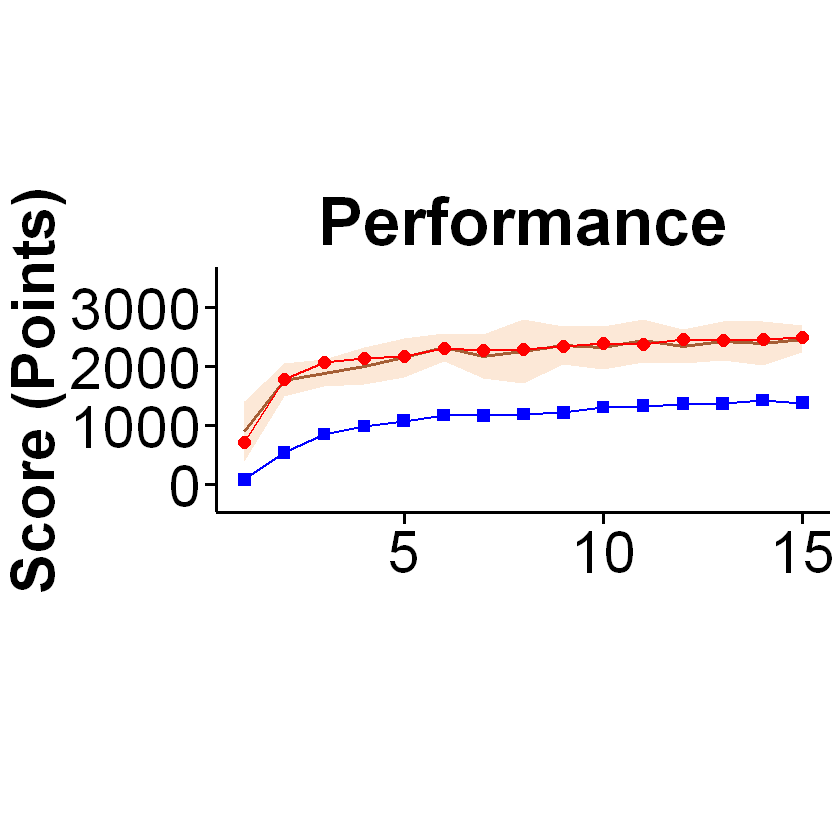

In [28]:
#Performance
fast_data <- data %>% filter(!Agent=='Coupled_Strategy')
Shaded <- fast_data %>% filter(Agent==cur_strategy)
Hybrid_data <- fast_data %>% filter(Agent=='Streamed')
MS17_data <- fast_data %>% filter(Agent=='MS17')
coupled_data <- fast_data %>% filter(Agent=='Coupled')

ar <- 0.4
datac2 <- summarySE(Shaded, measurevar="Score", groupvars=c("GameNb","Agent"))
datac3 <- summarySE(Hybrid_data, measurevar="Score", groupvars=c("GameNb","Agent"))
datac4 <- summarySE(MS17_data, measurevar="Score", groupvars=c("GameNb","Agent"))
datac5 <- summarySE(coupled_data, measurevar="Score", groupvars=c("GameNb","Agent"))

p0 <- ggplot(datac2) +  geom_line(aes(x=GameNb, y=Score,colour=Agent),size=1.0) + geom_ribbon(aes(x=GameNb, ymin=Score-sd, ymax=Score+sd, fill="Streamed_Strategy")) +
      theme_classic() +
      ggtitle("Performance") +
      theme(plot.title = element_text(size=40,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 36,color='black'),
           axis.line = element_line(colour = 'black', size = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 42,face ="bold",color='black'),
           axis.title = element_text( size = 36, face = "bold" ),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text( size = 40),
           legend.title = element_text( size = 40),
           legend.position = 'none', #change the legend here
           aspect.ratio=ar
          ) 
p0 <- p0+ geom_line(data = datac3, aes(x=GameNb, y=Score,color="Streamed"),linewidth=0.6) +
      geom_line(data = datac5, aes(x=GameNb, y=Score,color="Coupled"),linewidth=0.6) +
      geom_point(data = datac3, color = "red", aes(x=GameNb, y=Score), shape=19,size = 3.2) +
      geom_point(data = datac5, color = "blue", aes(x=GameNb, y=Score), shape=15,size = 3.2) +
      guides(color = guide_legend(override.aes = list(size=2))) +
      scale_fill_manual(values = alpha(c("sandybrown"), .25), name = "Variation (SD)") + 
      scale_color_manual(values = c("blue","red","sienna4"), name = "Agent means",labels=c("Coupled Model","Fast Humans","Hybrid Model")) + 
      scale_x_continuous(name="", breaks=seq(0,15,5)) +
      scale_y_continuous(name="Score (Points)", limits=c(-300, 3500))

p0
pathFig <- './Figures/Performance_lines.png'
ggsave(pathFig,p0,width=10,height=7)

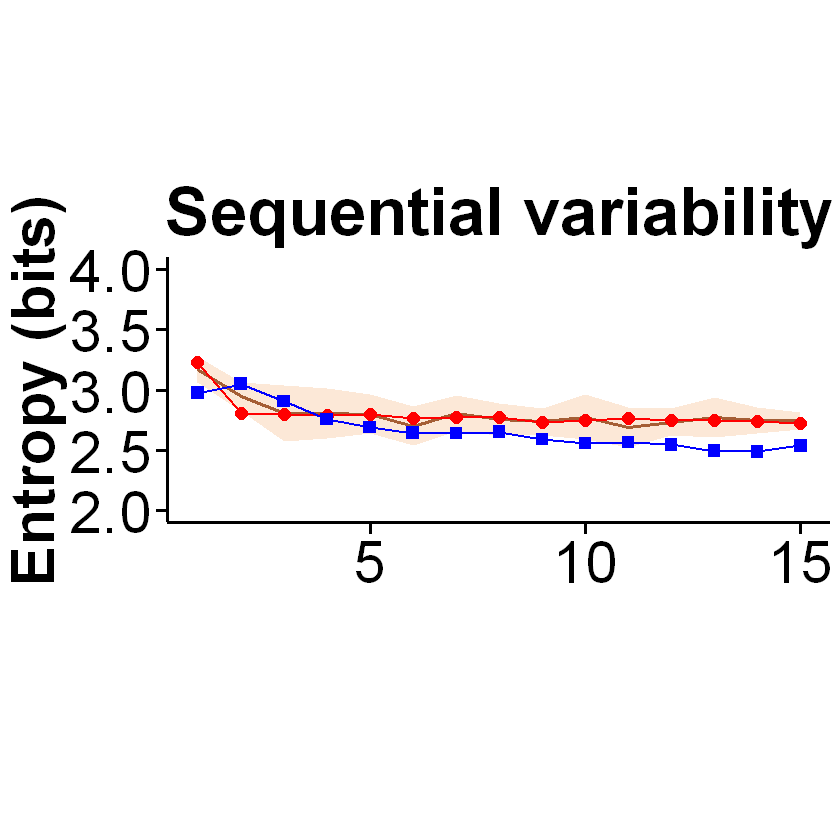

In [29]:
#Entropy - Sequential variability
fast_data <- data %>% filter(!Agent=='Coupled_Strategy')
#print(nrow(fast_data))
filtered_data <- fast_data %>% filter(!Entropy=='NaN')
#print(nrow(filtered_data))
Shaded <- filtered_data %>% filter(Agent==cur_strategy)
Hybrid_data <- filtered_data %>% filter(Agent=='Streamed')
MS17_data <- filtered_data %>% filter(Agent=='MS17')
coupled_data <- filtered_data %>% filter(Agent=='Coupled')

datac2 <- summarySE(Shaded, measurevar="Entropy", groupvars=c("GameNb","Agent"))
datac3 <-  summarySE(Hybrid_data, measurevar="Entropy", groupvars=c("GameNb","Agent"))
datac4 <-  summarySE(MS17_data, measurevar="Entropy", groupvars=c("GameNb","Agent"))
datac5 <- summarySE(coupled_data, measurevar="Entropy", groupvars=c("GameNb","Agent"))

p1 <- ggplot(datac2) +  geom_line(aes(x=GameNb, y=Entropy,colour=Agent),size=1.0) + geom_ribbon(aes(x=GameNb, ymin=Entropy-sd, ymax=Entropy+sd, fill="Streamed_Strategy")) +
      theme_classic() +
      ggtitle("Sequential variability") +
      theme(plot.title = element_text(size=40,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 36,color='black'),
           axis.line = element_line(colour = 'black', size = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 42,face ="bold",color='black'),
           axis.title = element_text( size = 36, face = "bold" ),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text( size = 40),
           legend.title = element_text( size = 40),
           legend.position = 'none', #change the legend here
           aspect.ratio=ar
          ) 
p1 <- p1+ geom_line(data = datac3, aes(x=GameNb, y=Entropy,color="Streamed"),linewidth=0.6) +      
      geom_line(data = datac5, aes(x=GameNb, y=Entropy,color="Coupled"),linewidth=0.6) +
      geom_point(data = datac3, color = "red", aes(x=GameNb, y=Entropy), shape=19,size = 3.2) +
      geom_point(data = datac5, color = "blue", aes(x=GameNb, y=Entropy), shape=15,size = 3.2) +
      guides(color = guide_legend(override.aes = list(size=2))) +
      scale_fill_manual(values = alpha(c("sandybrown"), .25), name = "Variation (SD)") + 
      scale_color_manual(values = c("blue","red","sienna4"), name = "Agent means",labels=c("Coupled Model","Fast Humans","Hybrid Model")) + 
      scale_x_continuous(name="", breaks=seq(0,15,5)) +
      scale_y_continuous(name="Entropy (bits)", limits=c(2.0,4.0))

p1
pathFig <- './Figures/Entropy_lines.png'
ggsave(pathFig,p1,width=10,height=7)

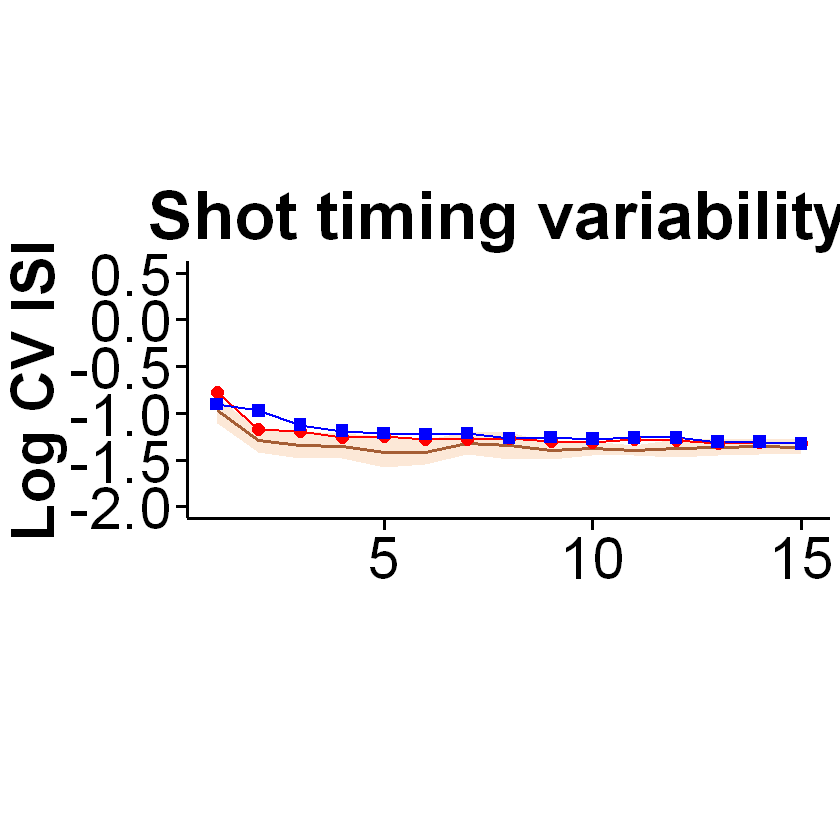

In [30]:
#Log CV ISI - Shot timing variability
fast_data <- data %>% filter(!Agent=='Coupled_Strategy')
#print(nrow(fast_data))
filtered_data <- fast_data %>% filter(!LogCV=='NaN')
#print(nrow(filtered_data))
Shaded <- filtered_data %>% filter(Agent==cur_strategy)
Hybrid_data <- filtered_data %>% filter(Agent=='Streamed')
MS17_data <- filtered_data %>% filter(Agent=='MS17')
coupled_data <- filtered_data %>% filter(Agent=='Coupled')

datac2 <- summarySE(Shaded, measurevar="LogCV", groupvars=c("GameNb","Agent"))
datac3 <-  summarySE(Hybrid_data, measurevar="LogCV", groupvars=c("GameNb","Agent"))
datac4 <-  summarySE(MS17_data, measurevar="LogCV", groupvars=c("GameNb","Agent"))
datac5 <- summarySE(coupled_data, measurevar="LogCV", groupvars=c("GameNb","Agent"))

p2 <- ggplot(datac2) +  geom_line(aes(x=GameNb, y=LogCV,colour=Agent),size=1.0) + geom_ribbon(aes(x=GameNb, ymin=LogCV-sd, ymax=LogCV+sd, fill="Streamed_Strategy")) +
      theme_classic() +
      ggtitle("Shot timing variability") +
      theme(plot.title = element_text(size=40,hjust=0.7,face ="bold"),
           axis.text = element_text(size = 36,color='black'),
           axis.line = element_line(colour = 'black', size = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 42,face ="bold",color='black'),
           axis.title = element_text( size = 36, face = "bold" ),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text( size = 40),
           legend.title = element_text( size = 40),
           legend.position = 'none', #change the legend here
           aspect.ratio=ar
          ) 
p2 <- p2+ geom_line(data = datac3, aes(x=GameNb, y=LogCV,color="Streamed"),linewidth=0.6) +
      geom_line(data = datac5, aes(x=GameNb, y=LogCV,color="Coupled"),linewidth=0.6) +
      geom_point(data = datac3, color = "red", aes(x=GameNb, y=LogCV), shape=19,size = 3.2) +
      geom_point(data = datac5, color = "blue", aes(x=GameNb, y=LogCV), shape=15,size = 3.2) +
      guides(color = guide_legend(override.aes = list(size=2))) +
      scale_fill_manual(values = alpha(c("sandybrown"), .25), name = "Variation (SD)") + 
      scale_color_manual(values = c("blue","red","sienna4"), name = "Agent means",labels=c("Coupled Model","Fast Humans","Hybrid Model")) + 
      scale_x_continuous(name="", breaks=seq(0,15,5)) +
      scale_y_continuous(name="Log CV ISI", limits=c(-2.0,0.5))

p2
pathFig <- './Figures/LogCV_lines.png'
ggsave(pathFig,p2,width=10,height=7)

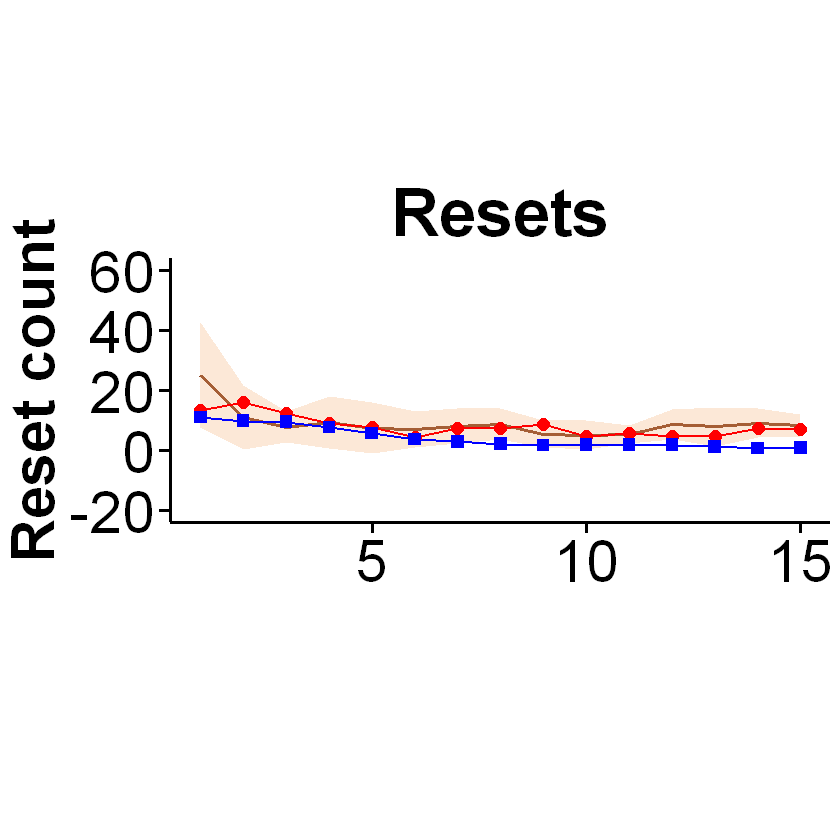

In [31]:
#Resets
fast_data <- data %>% filter(!Agent=='Coupled_Strategy')
Shaded <- fast_data %>% filter(Agent==cur_strategy)
Hybrid_data <- fast_data %>% filter(Agent=='Streamed')
MS17_data <- fast_data %>% filter(Agent=='MS17')
coupled_data <- fast_data %>% filter(Agent=='Coupled')

datac2 <- summarySE(Shaded, measurevar="Resets", groupvars=c("GameNb","Agent"))
datac3 <-  summarySE(Hybrid_data, measurevar="Resets", groupvars=c("GameNb","Agent"))
datac4 <-  summarySE(MS17_data, measurevar="Resets", groupvars=c("GameNb","Agent"))
datac5 <- summarySE(coupled_data, measurevar="Resets", groupvars=c("GameNb","Agent"))

p3 <- ggplot(datac2) +  geom_line(aes(x=GameNb, y=Resets,colour=Agent),size=1.0) + geom_ribbon(aes(x=GameNb, ymin=Resets-sd, ymax=Resets+sd, fill="Streamed_Strategy")) +
      theme_classic() +
      ggtitle("Resets") +
      theme(plot.title = element_text(size=40,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 36,color='black'),
           axis.line = element_line(colour = 'black', size = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 42,face ="bold",color='black'),
           axis.title = element_text( size = 36, face = "bold" ),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text( size = 40),
           legend.title = element_text( size = 40),
           legend.position = 'none', #change the legend here
           aspect.ratio=ar
          ) 
p3 <- p3+ geom_line(data = datac3, aes(x=GameNb, y=Resets,color="Streamed"),linewidth=0.6) +
      geom_line(data = datac5, aes(x=GameNb, y=Resets,color="Coupled"),linewidth=0.6) +
      geom_point(data = datac3, color = "red", aes(x=GameNb, y=Resets), shape=19,size = 3.2) +
      geom_point(data = datac5, color = "blue", aes(x=GameNb, y=Resets), shape=15,size = 3.2) +
      guides(color = guide_legend(override.aes = list(size=2))) +
      scale_fill_manual(values = alpha(c("sandybrown"), .25), name = "Variation (SD)") + 
      scale_color_manual(values = c("blue","red","sienna4"), name = "Agent means",labels=c("Coupled Model","Fast Humans","Hybrid Model")) + 
      scale_x_continuous(name="", breaks=seq(0,15,5)) +
      scale_y_continuous(name="Reset count", limits=c(-20,60))

p3
pathFig <- './Figures/Resets_lines.png'
ggsave(pathFig,p3,width=10,height=7)

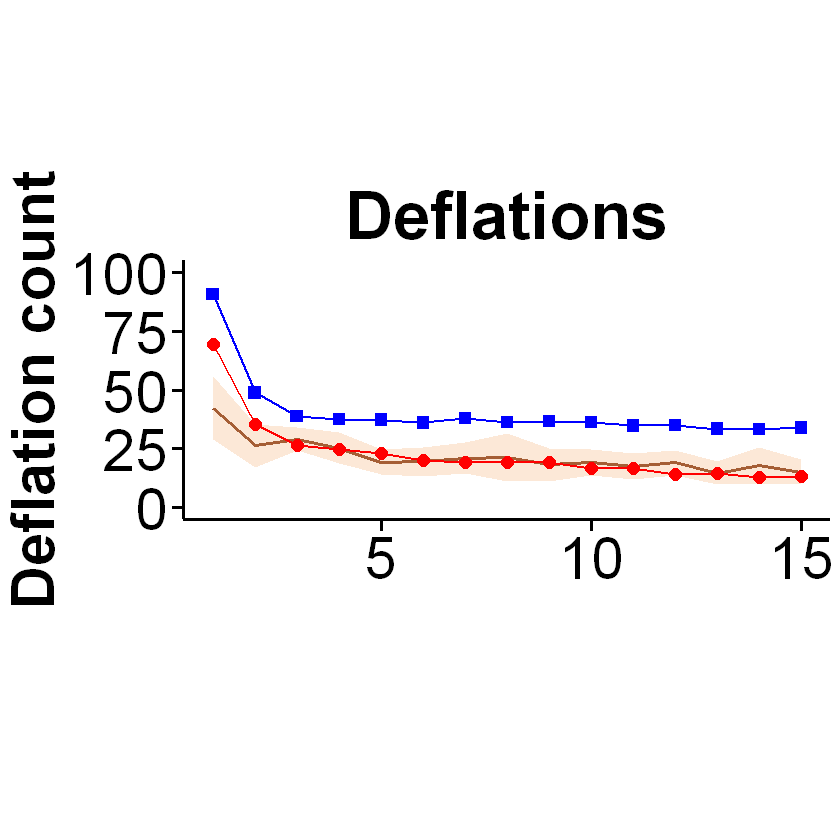

In [32]:
#Deflations
fast_data <- data %>% filter(!Agent=='Coupled_Strategy')
Shaded <- fast_data %>% filter(Agent==cur_strategy)
Hybrid_data <- fast_data %>% filter(Agent=='Streamed')
MS17_data <- fast_data %>% filter(Agent=='MS17')
coupled_data <- fast_data %>% filter(Agent=='Coupled')

datac2 <- summarySE(Shaded, measurevar="Deflations", groupvars=c("GameNb","Agent"))
datac3 <-  summarySE(Hybrid_data, measurevar="Deflations", groupvars=c("GameNb","Agent"))
datac4 <-  summarySE(MS17_data, measurevar="Deflations", groupvars=c("GameNb","Agent"))
datac5 <- summarySE(coupled_data, measurevar="Deflations", groupvars=c("GameNb","Agent"))

p4 <- ggplot(datac2) +  geom_line(aes(x=GameNb, y=Deflations,colour=Agent),size=1.0) + geom_ribbon(aes(x=GameNb, ymin=Deflations-sd, ymax=Deflations+sd, fill="Streamed_Strategy")) +
      theme_classic() +
      ggtitle("Deflations") +
      theme(plot.title = element_text(size=40,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 36,color='black'),
           axis.line = element_line(colour = 'black', size = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 42,face ="bold",color='black'),
           axis.title = element_text( size = 36, face = "bold" ),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text( size = 40),
           legend.title = element_text( size = 40),
           legend.position = 'none', #change the legend here
           aspect.ratio=ar
          ) 
p4 <- p4+ geom_line(data = datac3, aes(x=GameNb, y=Deflations,color="Streamed"),linewidth=0.6) +
      geom_line(data = datac5, aes(x=GameNb, y=Deflations,color="Coupled"),linewidth=0.6) +
      geom_point(data = datac3, color = "red", aes(x=GameNb, y=Deflations), shape=19,size = 3.2) +
      geom_point(data = datac5, color = "blue", aes(x=GameNb, y=Deflations), shape=15,size = 3.2) +
      guides(color = guide_legend(override.aes = list(size=2))) +
      scale_fill_manual(values = alpha(c("sandybrown"), .25), name = "Variation (SD)") + 
      scale_color_manual(values = c("blue","red","sienna4"), name = "Agent means",labels=c("Coupled Model","Fast Humans","Hybrid Model")) + 
      scale_x_continuous(name="", breaks=seq(0,15,5)) +
      scale_y_continuous(name="Deflation count", limits=c(0,100))

p4
pathFig <- './Figures/Deflations_lines.png'
ggsave(pathFig,p4,width=10,height=7)

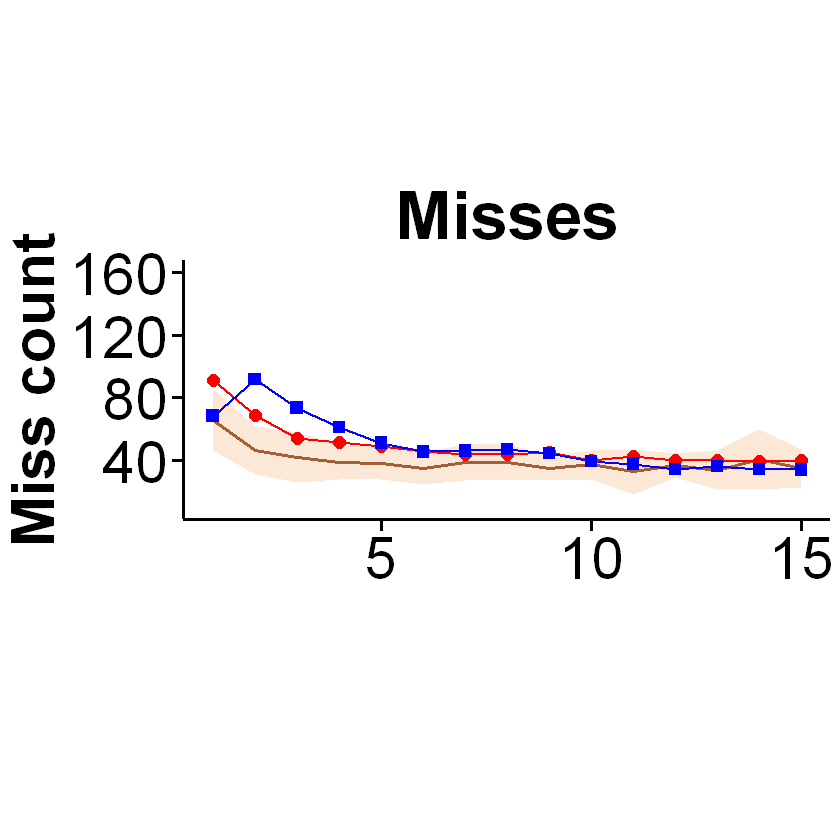

In [33]:
#Misses
fast_data <- data %>% filter(!Agent=='Coupled_Strategy')
Shaded <- fast_data %>% filter(Agent==cur_strategy)
Hybrid_data <- fast_data %>% filter(Agent=='Streamed')
MS17_data <- fast_data %>% filter(Agent=='MS17')
coupled_data <- fast_data %>% filter(Agent=='Coupled')

datac2 <- summarySE(Shaded, measurevar="Misses", groupvars=c("GameNb","Agent"))
datac3 <-  summarySE(Hybrid_data, measurevar="Misses", groupvars=c("GameNb","Agent"))
datac4 <-  summarySE(MS17_data, measurevar="Misses", groupvars=c("GameNb","Agent"))
datac5 <- summarySE(coupled_data, measurevar="Misses", groupvars=c("GameNb","Agent"))

p5 <- ggplot(datac2) +  geom_line(aes(x=GameNb, y=Misses,colour=Agent),size=1.0) + geom_ribbon(aes(x=GameNb, ymin=Misses-sd, ymax=Misses+sd, fill="Streamed_Strategy")) +
      theme_classic() +
      ggtitle("Misses") +
      theme(plot.title = element_text(size=40,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 36,color='black'),
           axis.line = element_line(colour = 'black', size = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 42,face ="bold",color='black'),
           axis.title = element_text( size = 36, face = "bold" ),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text( size = 40),
           legend.title = element_text( size = 40),
           legend.position = 'none', #change the legend here
           aspect.ratio=ar
          ) 
p5 <- p5+ geom_line(data = datac3, aes(x=GameNb, y=Misses,color="Streamed"),linewidth=0.6) +
      geom_line(data = datac5, aes(x=GameNb, y=Misses,color="Coupled"),linewidth=0.6) +
      geom_point(data = datac3, color = "red", aes(x=GameNb, y=Misses), shape=19,size = 3.2) +
      geom_point(data = datac5, color = "blue", aes(x=GameNb, y=Misses), shape=15,size = 3.2) +
      guides(color = guide_legend(override.aes = list(size=2))) +
      scale_fill_manual(values = alpha(c("sandybrown"), .25), name = "Variation (SD)") + 
      scale_color_manual(values = c("blue","red","sienna4"), name = "Agent means",labels=c("Coupled Model","Fast Humans","Hybrid Model")) + 
      scale_x_continuous(name="", breaks=seq(0,15,5)) +
      scale_y_continuous(name="Miss count", limits=c(10,160))

p5
pathFig <- './Figures/Misses_lines.png'
ggsave(pathFig,p5,width=10,height=7)

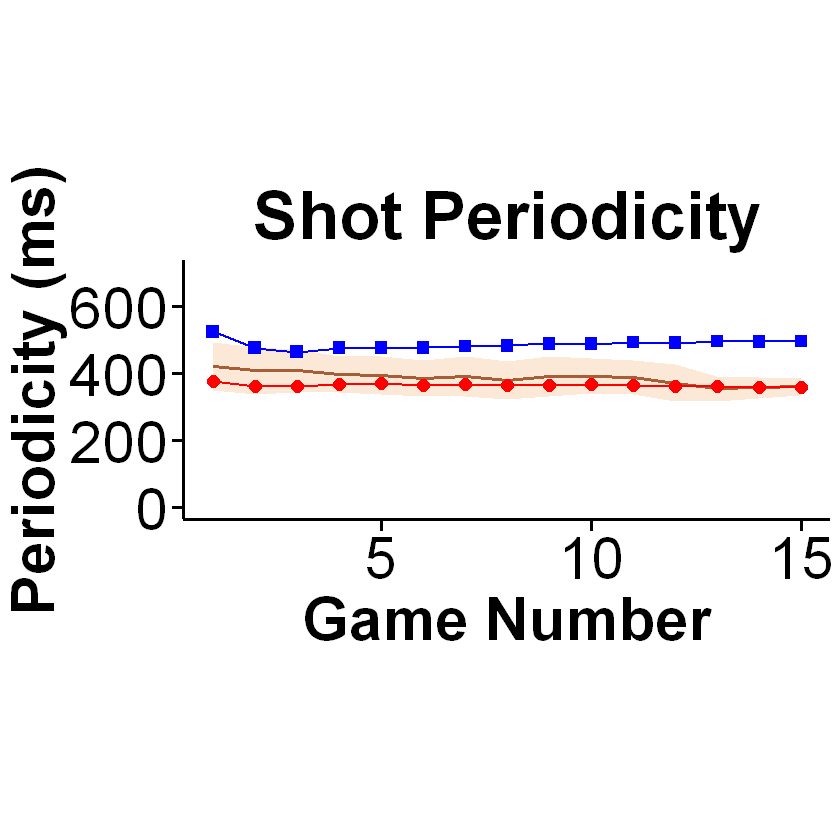

In [34]:
#Shot periodicity
fast_data <- data %>% filter(!Agent=='Coupled_Strategy')
#print(nrow(fast_data))
filtered_data <- fast_data %>% filter(!ShotPer=='NaN')
#print(nrow(filtered_data))
Shaded <- filtered_data %>% filter(Agent==cur_strategy)
Hybrid_data <- filtered_data %>% filter(Agent=='Streamed')
MS17_data <- filtered_data %>% filter(Agent=='MS17')
coupled_data <- filtered_data %>% filter(Agent=='Coupled')

datac2 <- summarySE(Shaded, measurevar="ShotPer", groupvars=c("GameNb","Agent"))
datac3 <-  summarySE(Hybrid_data, measurevar="ShotPer", groupvars=c("GameNb","Agent"))
datac4 <-  summarySE(MS17_data, measurevar="ShotPer", groupvars=c("GameNb","Agent"))
datac5 <- summarySE(coupled_data, measurevar="ShotPer", groupvars=c("GameNb","Agent"))

p6 <- ggplot(datac2) +  geom_line(aes(x=GameNb, y=ShotPer,colour=Agent),size=1.0) + geom_ribbon(aes(x=GameNb, ymin=ShotPer-sd, ymax=ShotPer+sd, fill="Streamed_Strategy")) +
      theme_classic() +
      ggtitle("Shot Periodicity") +
      theme(plot.title = element_text(size=40,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 36,color='black'),
           axis.line = element_line(colour = 'black', size = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 42,face ="bold",color='black'),
           axis.title = element_text( size = 36, face = "bold" ),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text( size = 40),
           legend.title = element_text( size = 40),
           legend.position = 'none', #change the legend here
           aspect.ratio=ar
          ) 
p6 <- p6+ geom_line(data = datac3, aes(x=GameNb, y=ShotPer,color="Streamed"),linewidth=0.6) +
      geom_line(data = datac5, aes(x=GameNb, y=ShotPer,color="Coupled"),linewidth=0.6) +
      geom_point(data = datac3, color = "red", aes(x=GameNb, y=ShotPer), shape=19,size = 3.2) +
      geom_point(data = datac5, color = "blue", aes(x=GameNb, y=ShotPer), shape=15,size = 3.2) +
      guides(color = guide_legend(override.aes = list(size=2))) +
      scale_fill_manual(values = alpha(c("sandybrown"), .25), name = "Variation (SD)") + 
      scale_color_manual(values = c("blue","red","sienna4"), name = "Agent means",labels=c("Coupled Model","Fast Humans","Hybrid Model")) + 
      scale_x_continuous(name="Game Number", breaks=seq(0,15,5)) +
      scale_y_continuous(name="Periodicity (ms)", limits=c(0,700))

p6
pathFig <- './Figures/ShotPeriodicity_lines.png'
ggsave(pathFig,p6,width=10,height=7)

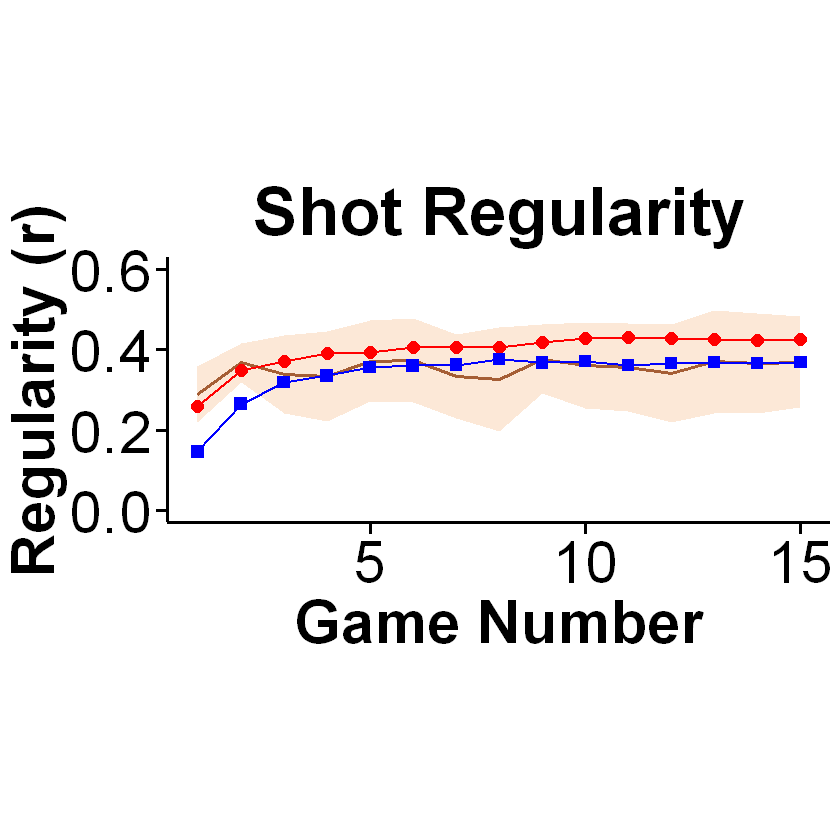

In [35]:
#Shot regularity
fast_data <- data %>% filter(!Agent=='Coupled_Strategy')
#print(nrow(fast_data))
filtered_data <- fast_data %>% filter(!ShotReg=='NaN')
#print(nrow(filtered_data))
Shaded <- filtered_data %>% filter(Agent==cur_strategy)
Hybrid_data <- filtered_data %>% filter(Agent=='Streamed')
MS17_data <- filtered_data %>% filter(Agent=='MS17')
coupled_data <- filtered_data %>% filter(Agent=='Coupled')

datac2 <- summarySE(Shaded, measurevar="ShotReg", groupvars=c("GameNb","Agent"))
datac3 <-  summarySE(Hybrid_data, measurevar="ShotReg", groupvars=c("GameNb","Agent"))
datac4 <-  summarySE(MS17_data, measurevar="ShotReg", groupvars=c("GameNb","Agent"))
datac5 <- summarySE(coupled_data, measurevar="ShotReg", groupvars=c("GameNb","Agent"))

p7 <- ggplot(datac2) +  geom_line(aes(x=GameNb, y=ShotReg,colour=Agent),size=1.0) + geom_ribbon(aes(x=GameNb, ymin=ShotReg-sd, ymax=ShotReg+sd, fill="Streamed_Strategy")) +
      theme_classic() +
      ggtitle("Shot Regularity") +
      theme(plot.title = element_text(size=40,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 36,color='black'),
           axis.line = element_line(colour = 'black', size = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 42,face ="bold",color='black'),
           axis.title = element_text( size = 36, face = "bold" ),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text( size = 40),
           legend.title = element_text( size = 40),
           legend.position = 'none', #change the legend here
           aspect.ratio=ar
          ) 
p7 <- p7+ geom_line(data = datac3, aes(x=GameNb, y=ShotReg,color="Streamed"),linewidth=0.6) +
      geom_line(data = datac5, aes(x=GameNb, y=ShotReg,color="Coupled"),linewidth=0.6) +
      geom_point(data = datac3, color = "red", aes(x=GameNb, y=ShotReg), shape=19,size = 3.2) +
      geom_point(data = datac5, color = "blue", aes(x=GameNb, y=ShotReg), shape=15,size = 3.2) +
      guides(color = guide_legend(override.aes = list(size=2))) +
      scale_fill_manual(values = alpha(c("sandybrown"), .25), name = "Variation (SD)") + 
      scale_color_manual(values = c("blue","red","sienna4"), name = "Agent means",labels=c("Coupled Model","Fast Humans","Hybrid Model")) + 
      scale_x_continuous(name="Game Number", breaks=seq(0,15,5)) +
      scale_y_continuous(name="Regularity (r)", limits=c(0.0,0.6))

p7
pathFig <- './Figures/ShotRegularity_lines.png'
ggsave(pathFig,p7,width=10,height=7)

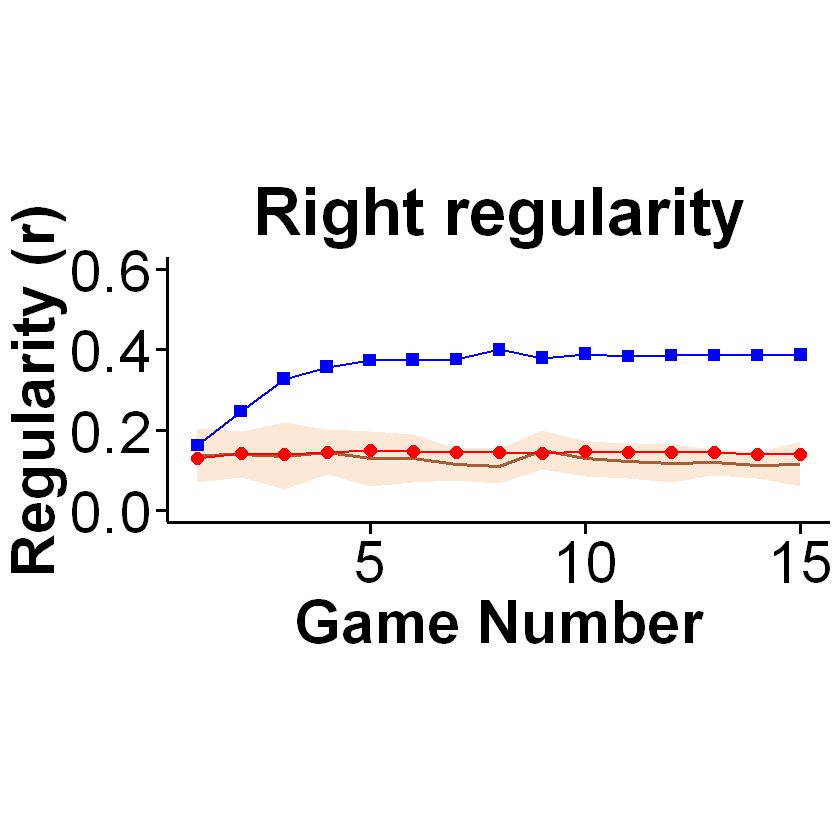

In [36]:
#Right regularity
fast_data <- data %>% filter(!Agent=='Coupled_Strategy')
#print(nrow(fast_data))
filtered_data <- fast_data %>% filter(!ShotReg=='NaN')
#print(nrow(filtered_data))
Shaded <- filtered_data %>% filter(Agent==cur_strategy)
Hybrid_data <- filtered_data %>% filter(Agent=='Streamed')
MS17_data <- filtered_data %>% filter(Agent=='MS17')
coupled_data <- filtered_data %>% filter(Agent=='Coupled')

datac2 <- summarySE(Shaded, measurevar="RightReg", groupvars=c("GameNb","Agent"))
datac3 <-  summarySE(Hybrid_data, measurevar="RightReg", groupvars=c("GameNb","Agent"))
datac4 <-  summarySE(MS17_data, measurevar="RightReg", groupvars=c("GameNb","Agent"))
datac5 <- summarySE(coupled_data, measurevar="RightReg", groupvars=c("GameNb","Agent"))

p8 <- ggplot(datac2) +  geom_line(aes(x=GameNb, y=RightReg,colour=Agent),size=1.0) + geom_ribbon(aes(x=GameNb, ymin=RightReg-sd, ymax=RightReg+sd, fill="Streamed_Strategy")) +
      theme_classic() +
      ggtitle("Right regularity") +
      theme(plot.title = element_text(size=40,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 36,color='black'),
           axis.line = element_line(colour = 'black', size = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 42,face ="bold",color='black'),
           axis.title = element_text( size = 36, face = "bold" ),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text( size = 40),
           legend.title = element_text( size = 40),
           legend.position = 'none', #change the legend here
           aspect.ratio=ar
          ) 
p8 <- p8+ geom_line(data = datac3, aes(x=GameNb, y=RightReg,color="Streamed"),linewidth=0.6) +
      geom_line(data = datac5, aes(x=GameNb, y=RightReg,color="Coupled"),linewidth=0.6) +
      geom_point(data = datac3, color = "red", aes(x=GameNb, y=RightReg), shape=19,size = 3.2) +
      geom_point(data = datac5, color = "blue", aes(x=GameNb, y=RightReg), shape=15,size = 3.2) +
      guides(color = guide_legend(override.aes = list(size=2))) +
      scale_fill_manual(values = alpha(c("sandybrown"), .25), name = "Variation (SD)") + 
      scale_color_manual(values = c("blue","red","sienna4"), name = "Agent means",labels=c("Coupled Model","Fast Humans","Hybrid Model")) + 
      scale_x_continuous(name="Game Number", breaks=seq(0,15,5)) +
      scale_y_continuous(name="Regularity (r)", limits=c(0,0.6))

p8
pathFig <- './Figures/RightRegularity_lines.png'
ggsave(pathFig,p8,width=10,height=7)

In [37]:
# simple grid
gg <- plot_grid(p0,p1,p2,p3,p4,p5,p6,p7,p8,nrow=3)
ggsave("./Figures/Multi_LineGraphs_fast.png",gg,width=25,height=13)

# Plot line graphs - Slow-shooting data

In [39]:
cur_strategy <- 'Coupled_Strategy'

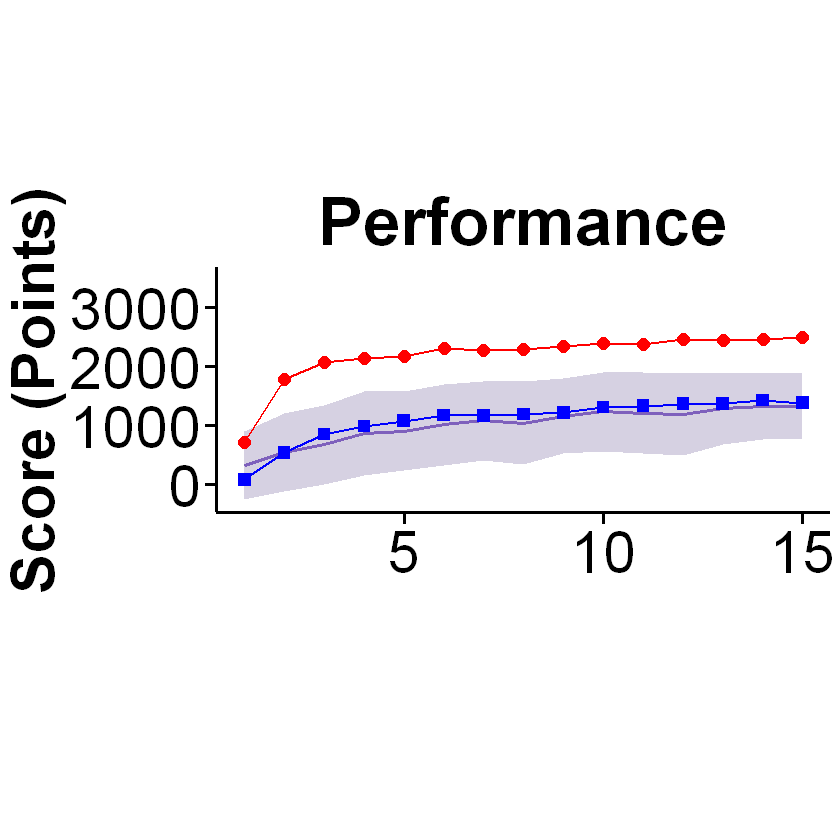

In [40]:
#Performance
slow_data <- data %>% filter(!Agent=='Streamed_Strategy')
Shaded <- slow_data %>% filter(Agent==cur_strategy)
Blending_data <- slow_data %>% filter(Agent=='Coupled')
MS17_data <- slow_data %>% filter(Agent=='MS17')
Hybrid_data <- slow_data %>% filter(Agent=='Streamed')

ar <- 0.4
datac2 <- summarySE(Shaded, measurevar="Score", groupvars=c("GameNb","Agent"),na.rm=TRUE)
datac3 <-  summarySE(Blending_data, measurevar="Score", groupvars=c("GameNb","Agent"),na.rm=TRUE)
datac4 <-  summarySE(MS17_data, measurevar="Score", groupvars=c("GameNb","Agent"),na.rm=TRUE)
datac5 <- summarySE(Hybrid_data, measurevar="Score", groupvars=c("GameNb","Agent"),na.rm=TRUE)

p0 <- ggplot(datac2) +  geom_line(aes(x=GameNb, y=Score,colour=Agent),size=1.0) + geom_ribbon(aes(x=GameNb, ymin=Score-sd, ymax=Score+sd, fill="Coupled_Strategy")) +
      theme_classic() +
      ggtitle("Performance") +
      theme(plot.title = element_text(size=40,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 36,color='black'),
           axis.line = element_line(colour = 'black', size = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 42,face ="bold",color='black'),
           axis.title = element_text( size = 36, face = "bold" ),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text( size = 40),
           legend.title = element_text( size = 40),
           legend.position = 'none', #change the legend here
           aspect.ratio=ar
          ) 
p0 <- p0+ geom_line(data = datac3, aes(x=GameNb, y=Score,color="Coupled"),linewidth=0.6) +
      geom_line(data = datac5, aes(x=GameNb, y=Score,color="Streamed"),linewidth=0.6) +
      geom_point(data = datac3, color = "blue", aes(x=GameNb, y=Score), shape=15,size = 3.2) +
      geom_point(data = datac5, color = "red", aes(x=GameNb, y=Score), shape=19,size = 3.2) +
      guides(color = guide_legend(override.aes = list(size=2))) +
      scale_fill_manual(values = alpha(c("mediumpurple4"), .25), name = "Variation (SD)") + 
      scale_color_manual(values = c("blue","mediumpurple3","red"), name = "Agent means",labels=c("Coupled Model","Slow Humans","Hybrid Model")) + 
      scale_x_continuous(name="", breaks=seq(0,15,5)) +
      scale_y_continuous(name="Score (Points)", limits=c(-300, 3500))

p0
pathFig <- './Figures_Slow/Performance_lines.png'
ggsave(pathFig,p0,width=10,height=7)

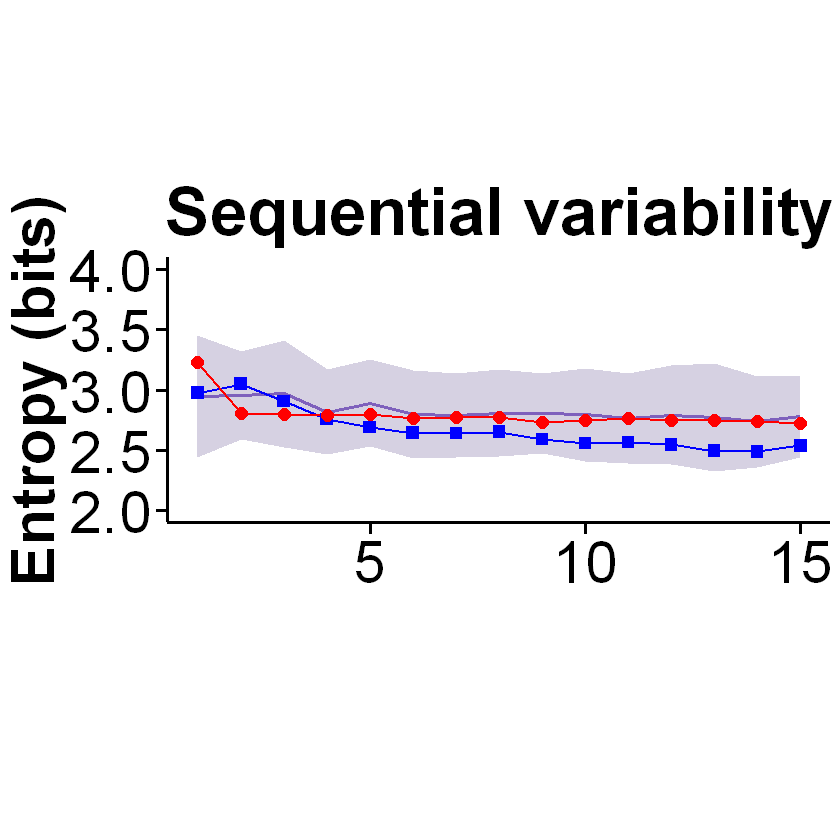

In [41]:
#Entropy - Sequential variability
slow_data <- data %>% filter(!Agent=='Streamed_Strategy')
#print(nrow(slow_data))
filtered_data <- slow_data %>% filter(!Entropy=='NaN') %>% filter(!Entropy=='NA')
#print(nrow(filtered_data))
Shaded <- filtered_data %>% filter(Agent==cur_strategy)
Blending_data <- filtered_data %>% filter(Agent=='Coupled')
MS17_data <- filtered_data %>% filter(Agent=='MS17')
Hybrid_data <- filtered_data %>% filter(Agent=='Streamed')

datac2 <- summarySE(Shaded, measurevar="Entropy", groupvars=c("GameNb","Agent"),na.rm=TRUE)
datac3 <-  summarySE(Blending_data, measurevar="Entropy", groupvars=c("GameNb","Agent"),na.rm=TRUE)
datac4 <-  summarySE(MS17_data, measurevar="Entropy", groupvars=c("GameNb","Agent"),na.rm=TRUE)
datac5 <- summarySE(Hybrid_data, measurevar="Entropy", groupvars=c("GameNb","Agent"),na.rm=TRUE)

p1 <- ggplot(datac2) +  geom_line(aes(x=GameNb, y=Entropy,colour=Agent),size=1.0) + geom_ribbon(aes(x=GameNb, ymin=Entropy-sd, ymax=Entropy+sd, fill="Coupled_Strategy")) +
      theme_classic() +
      ggtitle("Sequential variability") +
      theme(plot.title = element_text(size=40,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 36,color='black'),
           axis.line = element_line(colour = 'black', size = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 42,face ="bold",color='black'),
           axis.title = element_text( size = 36, face = "bold" ),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text( size = 40),
           legend.title = element_text( size = 40),
           legend.position = 'none', #change the legend here
           aspect.ratio=ar
          ) 
p1 <- p1+ geom_line(data = datac3, aes(x=GameNb, y=Entropy,color="Coupled"),linewidth=0.6) +
      geom_line(data = datac5, aes(x=GameNb, y=Entropy,color="Streamed"),linewidth=0.6) +
      geom_point(data = datac3, color = "blue", aes(x=GameNb, y=Entropy), shape=15,size = 3.2) +
      geom_point(data = datac5, color = "red", aes(x=GameNb, y=Entropy), shape=19,size = 3.2) +
      guides(color = guide_legend(override.aes = list(size=2))) +
      scale_fill_manual(values = alpha(c("mediumpurple4"), .25), name = "Variation (SD)") + 
      scale_color_manual(values = c("blue","mediumpurple3","red"), name = "Agent means",labels=c("Coupled Model","Slow Humans","Hybrid Model")) + 
      scale_x_continuous(name="", breaks=seq(0,15,5)) +
      scale_y_continuous(name="Entropy (bits)", limits=c(2.0,4.0))

p1
pathFig <- './Figures_Slow/Entropy_lines.png'
ggsave(pathFig,p1,width=10,height=7)

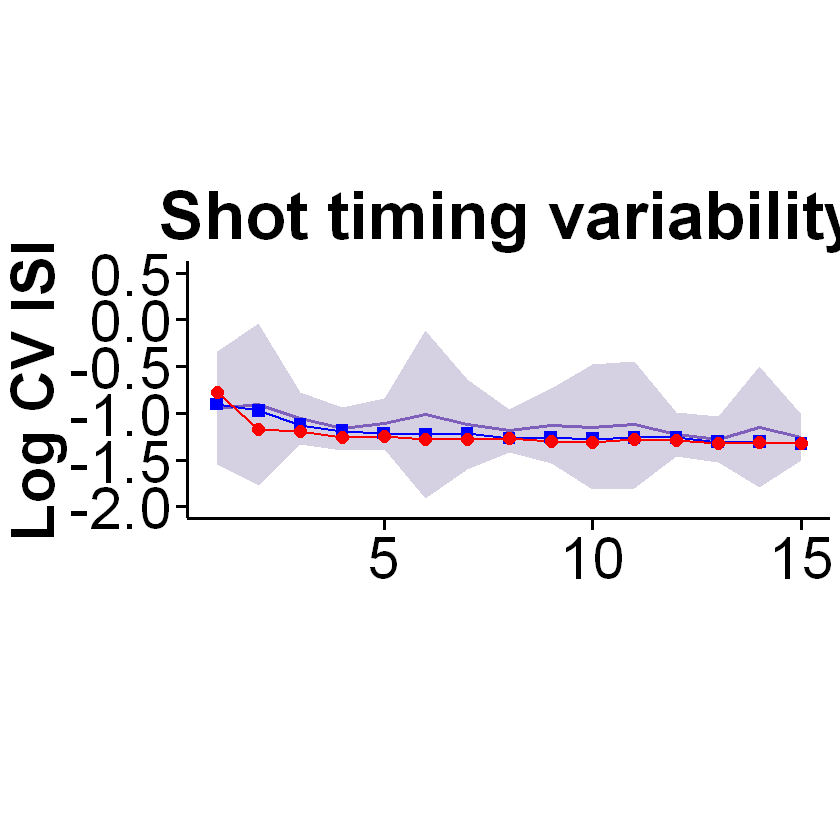

In [42]:
#Log CV ISI - Shot timing variability
slow_data <- data %>% filter(!Agent=='Streamed_Strategy')
#print(nrow(slow_data))
filtered_data <- slow_data %>% filter(!LogCV=='NaN')
#print(nrow(filtered_data))
Shaded <- filtered_data %>% filter(Agent==cur_strategy)
Blending_data <- filtered_data %>% filter(Agent=='Coupled')
MS17_data <- filtered_data %>% filter(Agent=='MS17')
Hybrid_data <- filtered_data %>% filter(Agent=='Streamed')

datac2 <- summarySE(Shaded, measurevar="LogCV", groupvars=c("GameNb","Agent"),na.rm=TRUE)
datac3 <-  summarySE(Blending_data, measurevar="LogCV", groupvars=c("GameNb","Agent"),na.rm=TRUE)
datac4 <-  summarySE(MS17_data, measurevar="LogCV", groupvars=c("GameNb","Agent"),na.rm=TRUE)
datac5 <- summarySE(Hybrid_data, measurevar="LogCV", groupvars=c("GameNb","Agent"),na.rm=TRUE)

p2 <- ggplot(datac2) +  geom_line(aes(x=GameNb, y=LogCV,colour=Agent),size=1.0) + geom_ribbon(aes(x=GameNb, ymin=LogCV-sd, ymax=LogCV+sd, fill="Streamed_Strategy")) +
      theme_classic() +
      ggtitle("Shot timing variability") +
      theme(plot.title = element_text(size=40,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 36,color='black'),
           axis.line = element_line(colour = 'black', size = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 42,face ="bold",color='black'),
           axis.title = element_text( size = 36, face = "bold" ),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text( size = 40),
           legend.title = element_text( size = 40),
           legend.position = 'none', #change the legend here
           aspect.ratio=ar
          ) 
p2 <- p2+ geom_line(data = datac3, aes(x=GameNb, y=LogCV,color="Coupled"),linewidth=0.6) +
      geom_line(data = datac5, aes(x=GameNb, y=LogCV,color="Streamed"),linewidth=0.6) +
      geom_point(data = datac3, color = "blue", aes(x=GameNb, y=LogCV), shape=15,size = 3.2) +
      geom_point(data = datac5, color = "red", aes(x=GameNb, y=LogCV), shape=19,size = 3.2) +
      guides(color = guide_legend(override.aes = list(size=2))) +
      scale_fill_manual(values = alpha(c("mediumpurple4"), .25), name = "Variation (SD)") + 
      scale_color_manual(values = c("blue","mediumpurple3","red"), name = "Agent means",labels=c("Coupled Model","Slow Humans","Hybrid Model")) + 
      scale_x_continuous(name="", breaks=seq(0,15,5)) +
      scale_y_continuous(name="Log CV ISI", limits=c(-2.0,0.5))

p2
pathFig <- './Figures_Slow/LogCV_lines.png'
ggsave(pathFig,p2,width=10,height=7)

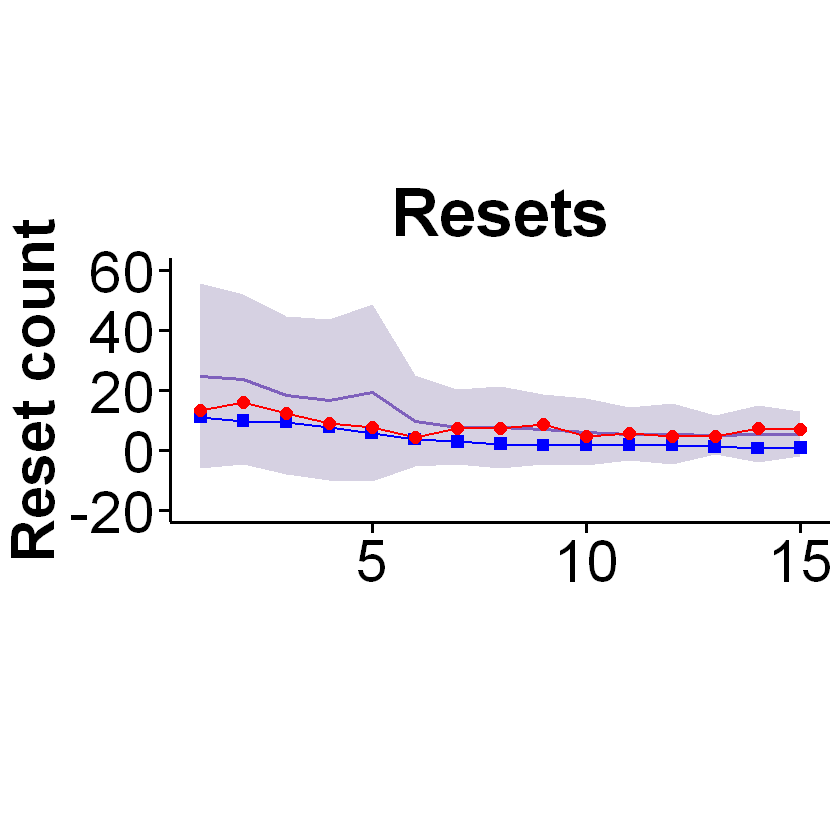

In [43]:
#Resets
slow_data <- data %>% filter(!Agent=='Streamed_Strategy')
Shaded <- slow_data %>% filter(Agent==cur_strategy)
Blending_data <- slow_data %>% filter(Agent=='Coupled')
MS17_data <- slow_data %>% filter(Agent=='MS17')
Hybrid_data <- slow_data %>% filter(Agent=='Streamed')

datac2 <- summarySE(Shaded, measurevar="Resets", groupvars=c("GameNb","Agent"),na.rm=TRUE)
datac3 <-  summarySE(Blending_data, measurevar="Resets", groupvars=c("GameNb","Agent"),na.rm=TRUE)
datac4 <-  summarySE(MS17_data, measurevar="Resets", groupvars=c("GameNb","Agent"),na.rm=TRUE)
datac5 <- summarySE(Hybrid_data, measurevar="Resets", groupvars=c("GameNb","Agent"),na.rm=TRUE)

p3 <- ggplot(datac2) +  geom_line(aes(x=GameNb, y=Resets,colour=Agent),size=1.0) + geom_ribbon(aes(x=GameNb, ymin=Resets-sd, ymax=Resets+sd, fill="Streamed_Strategy")) +
      theme_classic() +
      ggtitle("Resets") +
      theme(plot.title = element_text(size=40,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 36,color='black'),
           axis.line = element_line(colour = 'black', size = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 42,face ="bold",color='black'),
           axis.title = element_text( size = 36, face = "bold" ),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text( size = 40),
           legend.title = element_text( size = 40),
           legend.position = 'none', #change the legend here
           aspect.ratio=ar
          ) 
p3 <- p3+ geom_line(data = datac3, aes(x=GameNb, y=Resets,color="Coupled"),linewidth=0.6) +
      geom_line(data = datac5, aes(x=GameNb, y=Resets,color="Streamed"),linewidth=0.6) +
      geom_point(data = datac3, color = "blue", aes(x=GameNb, y=Resets), shape=15,size = 3.2) +
      geom_point(data = datac5, color = "red", aes(x=GameNb, y=Resets), shape=19,size = 3.2) +
      guides(color = guide_legend(override.aes = list(size=2))) +
      scale_fill_manual(values = alpha(c("mediumpurple4"), .25), name = "Variation (SD)") + 
      scale_color_manual(values = c("blue","mediumpurple3","red"), name = "Agent means",labels=c("Coupled Model","MS17 Model","Slow Humans","Hybrid Model")) + 
      scale_x_continuous(name="", breaks=seq(0,15,5)) +
      scale_y_continuous(name="Reset count", limits=c(-20,60))

p3
pathFig <- './Figures_Slow/Resets_lines.png'
ggsave(pathFig,p3,width=10,height=7)

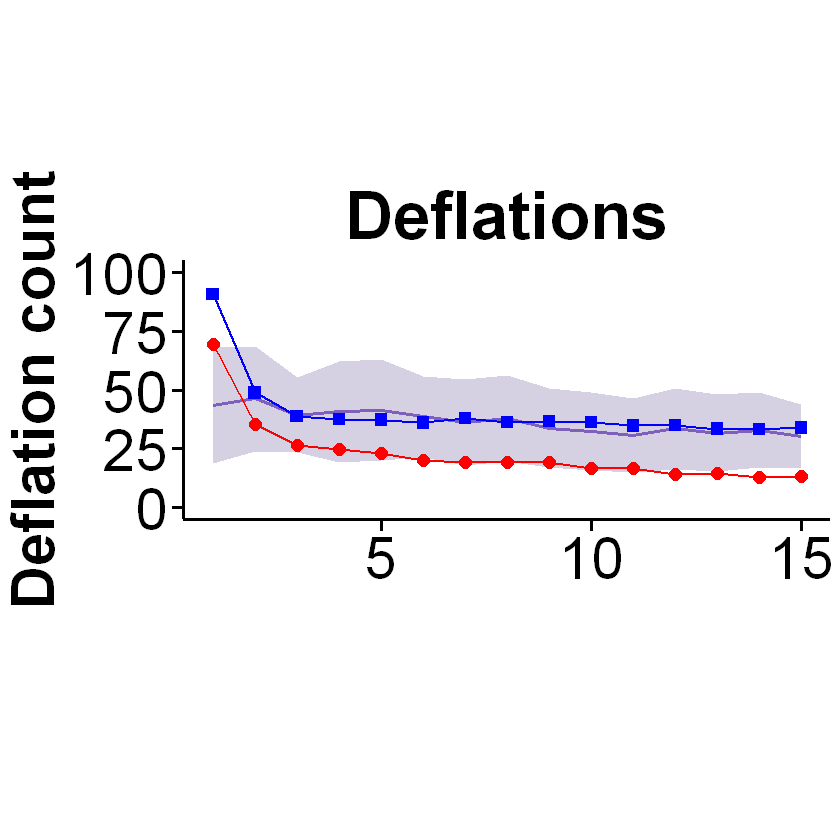

In [44]:
#Deflations
slow_data <- data %>% filter(!Agent=='Streamed_Strategy')
#filtered_data <- slow_data %>% filter(!Deflations=='NaN')
Shaded <- slow_data %>% filter(Agent==cur_strategy)
Blending_data <- slow_data %>% filter(Agent=='Coupled')
MS17_data <- slow_data %>% filter(Agent=='MS17')
Hybrid_data <- slow_data %>% filter(Agent=='Streamed')

datac2 <- summarySE(Shaded, measurevar="Deflations", groupvars=c("GameNb","Agent"),na.rm=TRUE)
datac3 <-  summarySE(Blending_data, measurevar="Deflations", groupvars=c("GameNb","Agent"),na.rm=TRUE)
datac4 <-  summarySE(MS17_data, measurevar="Deflations", groupvars=c("GameNb","Agent"),na.rm=TRUE)
datac5 <- summarySE(Hybrid_data, measurevar="Deflations", groupvars=c("GameNb","Agent"),na.rm=TRUE)

p4 <- ggplot(datac2) +  geom_line(aes(x=GameNb, y=Deflations,colour=Agent),size=1.0) + geom_ribbon(aes(x=GameNb, ymin=Deflations-sd, ymax=Deflations+sd, fill="Streamed_Strategy")) +
      theme_classic() +
      ggtitle("Deflations") +
      theme(plot.title = element_text(size=40,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 36,color='black'),
           axis.line = element_line(colour = 'black', size = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 42,face ="bold",color='black'),
           axis.title = element_text( size = 36, face = "bold" ),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text( size = 40),
           legend.title = element_text( size = 40),
           legend.position = 'none', #change the legend here
           aspect.ratio=ar
          ) 
p4 <- p4+ geom_line(data = datac3, aes(x=GameNb, y=Deflations,color="Coupled"),linewidth=0.6) +
      geom_line(data = datac5, aes(x=GameNb, y=Deflations,color="Streamed"),linewidth=0.6) +
      geom_point(data = datac3, color = "blue", aes(x=GameNb, y=Deflations), shape=15,size = 3.2) +
      geom_point(data = datac5, color = "red", aes(x=GameNb, y=Deflations), shape=19,size = 3.2) +
      guides(color = guide_legend(override.aes = list(size=2))) +
      scale_fill_manual(values = alpha(c("mediumpurple4"), .25), name = "Variation (SD)") + 
      scale_color_manual(values = c("blue","mediumpurple3","red"), name = "Agent means",labels=c("Coupled Model","Slow Humans","Hybrid Model")) + 
      scale_x_continuous(name="", breaks=seq(0,15,5)) +
      scale_y_continuous(name="Deflation count", limits=c(0,100))

p4
pathFig <- './Figures_Slow/Deflations_lines.png'
ggsave(pathFig,p4,width=10,height=7)

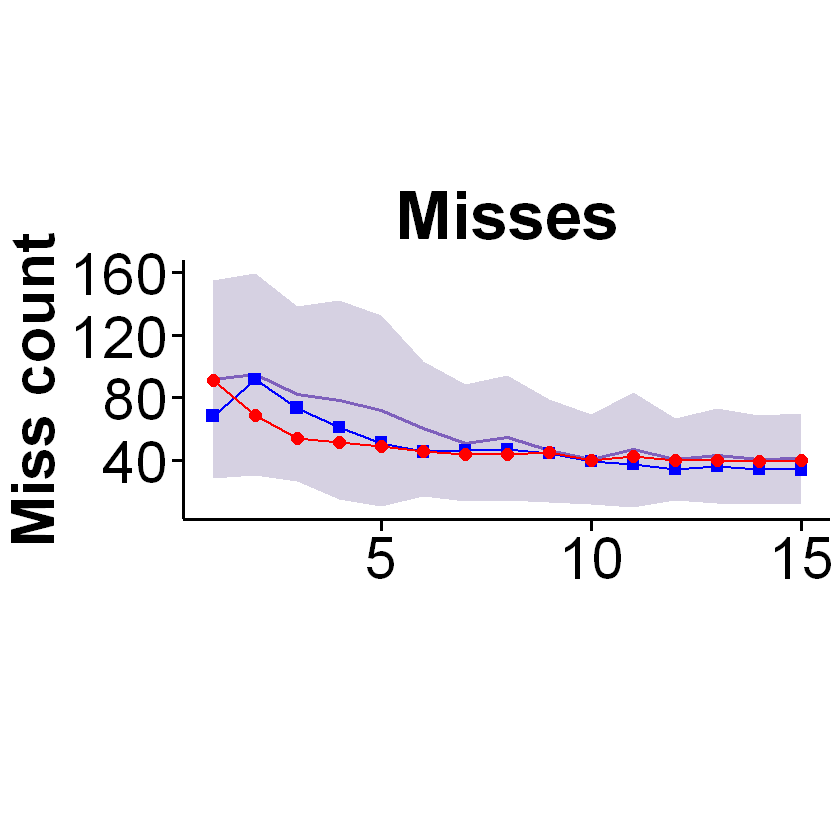

In [45]:
#Misses
slow_data <- data %>% filter(!Agent=='Streamed_Strategy')
Shaded <- slow_data %>% filter(Agent==cur_strategy)
Blending_data <- slow_data %>% filter(Agent=='Coupled')
MS17_data <- slow_data %>% filter(Agent=='MS17')
Hybrid_data <- slow_data %>% filter(Agent=='Streamed')

datac2 <- summarySE(Shaded, measurevar="Misses", groupvars=c("GameNb","Agent"),na.rm=TRUE)
datac3 <-  summarySE(Blending_data, measurevar="Misses", groupvars=c("GameNb","Agent"),na.rm=TRUE)
datac4 <-  summarySE(MS17_data, measurevar="Misses", groupvars=c("GameNb","Agent"),na.rm=TRUE)
datac5 <- summarySE(Hybrid_data, measurevar="Misses", groupvars=c("GameNb","Agent"),na.rm=TRUE)

p5 <- ggplot(datac2) +  geom_line(aes(x=GameNb, y=Misses,colour=Agent),size=1.0) + geom_ribbon(aes(x=GameNb, ymin=Misses-sd, ymax=Misses+sd, fill="Streamed_Strategy")) +
      theme_classic() +
      ggtitle("Misses") +
      theme(plot.title = element_text(size=40,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 36,color='black'),
           axis.line = element_line(colour = 'black', size = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 42,face ="bold",color='black'),
           axis.title = element_text( size = 36, face = "bold" ),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text( size = 40),
           legend.title = element_text( size = 40),
           legend.position = 'none', #change the legend here
           aspect.ratio=ar
          ) 
p5 <- p5+ geom_line(data = datac3, aes(x=GameNb, y=Misses,color="Coupled"),linewidth=0.6) +
      geom_line(data = datac5, aes(x=GameNb, y=Misses,color="Streamed"),linewidth=0.6) +
      geom_point(data = datac3, color = "blue", aes(x=GameNb, y=Misses), shape=15,size = 3.2) +
      geom_point(data = datac5, color = "red", aes(x=GameNb, y=Misses), shape=19,size = 3.2) +
      guides(color = guide_legend(override.aes = list(size=2))) +
      scale_fill_manual(values = alpha(c("mediumpurple4"), .25), name = "Variation (SD)") + 
      scale_color_manual(values = c("blue","mediumpurple3","red"), name = "Agent means",labels=c("Coupled Model","Slow Humans","Hybrid Model")) + 
      scale_x_continuous(name="", breaks=seq(0,15,5)) +
      scale_y_continuous(name="Miss count", limits=c(10,160))

p5
pathFig <- './Figures_Slow/Misses_lines.png'
ggsave(pathFig,p5,width=10,height=7)

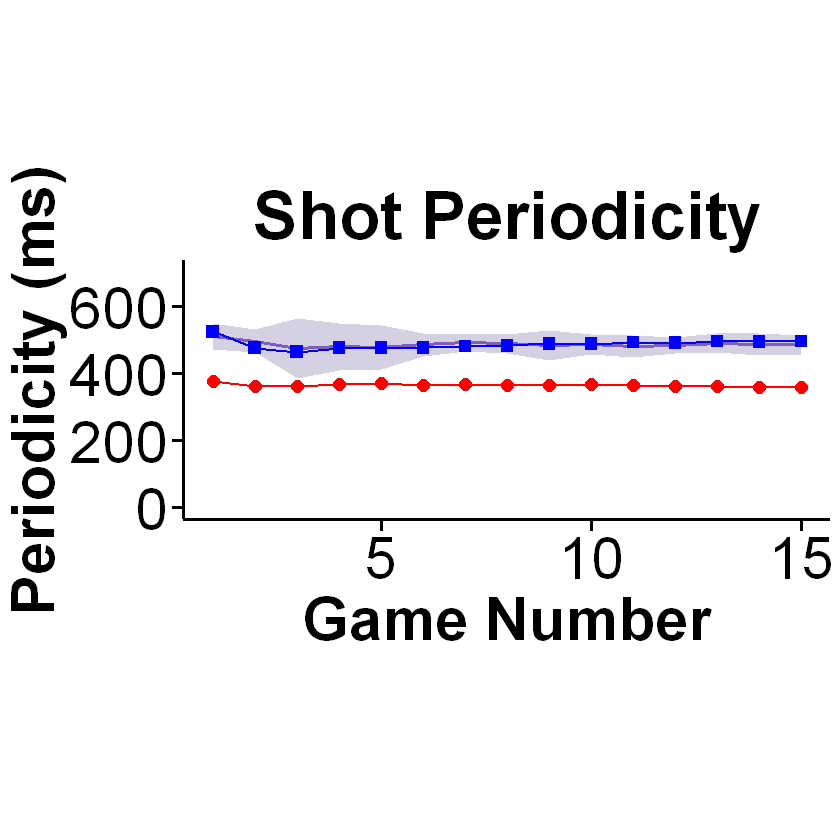

In [46]:
#Shot periodicity
slow_data <- data %>% filter(!Agent=='Streamed_Strategy')
#print(nrow(slow_data))
filtered_data <- slow_data %>% filter(!ShotPer=='NaN')
#print(nrow(filtered_data))
Shaded <- filtered_data %>% filter(Agent==cur_strategy)
Blending_data <- filtered_data %>% filter(Agent=='Coupled')
MS17_data <- filtered_data %>% filter(Agent=='MS17')
Hybrid_data <- filtered_data %>% filter(Agent=='Streamed')

datac2 <- summarySE(Shaded, measurevar="ShotPer", groupvars=c("GameNb","Agent"),na.rm=TRUE)
datac3 <-  summarySE(Blending_data, measurevar="ShotPer", groupvars=c("GameNb","Agent"),na.rm=TRUE)
datac4 <-  summarySE(MS17_data, measurevar="ShotPer", groupvars=c("GameNb","Agent"),na.rm=TRUE)
datac5 <- summarySE(Hybrid_data, measurevar="ShotPer", groupvars=c("GameNb","Agent"),na.rm=TRUE)

p6 <- ggplot(datac2) +  geom_line(aes(x=GameNb, y=ShotPer,colour=Agent),size=1.0) + geom_ribbon(aes(x=GameNb, ymin=ShotPer-sd, ymax=ShotPer+sd, fill="Streamed_Strategy")) +
      theme_classic() +
      ggtitle("Shot Periodicity") +
      theme(plot.title = element_text(size=40,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 36,color='black'),
           axis.line = element_line(colour = 'black', size = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 42,face ="bold",color='black'),
           axis.title = element_text( size = 36, face = "bold" ),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text( size = 40),
           legend.title = element_text( size = 40),
           legend.position = 'none', #change the legend here
           aspect.ratio=ar
          ) 
p6 <- p6+ geom_line(data = datac3, aes(x=GameNb, y=ShotPer,color="Coupled"),size=0.6) +
      geom_line(data = datac5, aes(x=GameNb, y=ShotPer,color="Streamed"),size=0.6) +
      geom_point(data = datac3, color = "blue", aes(x=GameNb, y=ShotPer), shape=15,size = 3.2) +
      geom_point(data = datac5, color = "red", aes(x=GameNb, y=ShotPer), shape=19,size = 3.2) +
      guides(color = guide_legend(override.aes = list(size=2))) +
      scale_fill_manual(values = alpha(c("mediumpurple4"), .25), name = "Variation (SD)") + 
      scale_color_manual(values = c("blue","mediumpurple3","red"), name = "Agent means",labels=c("Coupled Model","Slow Humans","Hybrid Model")) + 
      scale_x_continuous(name="Game Number", breaks=seq(0,15,5)) +
      scale_y_continuous(name="Periodicity (ms)", limits=c(0,700))

p6
pathFig <- './Figures_Slow/ShotPeriodicity_lines.png'
ggsave(pathFig,p6,width=10,height=7)

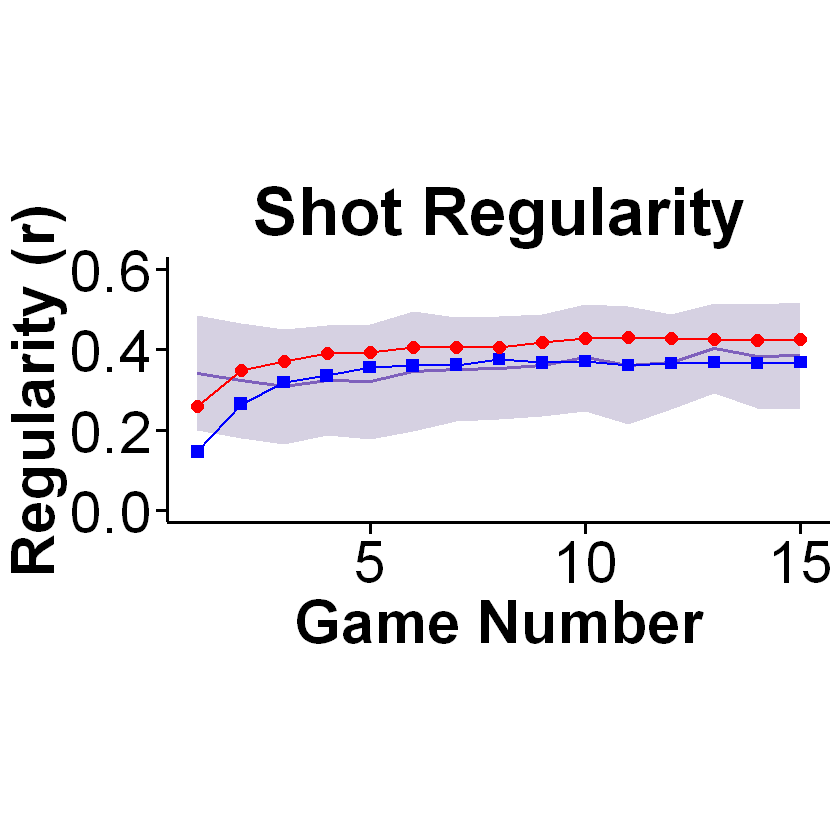

In [47]:
#Shot regularity
slow_data <- data %>% filter(!Agent=='Streamed_Strategy')
#print(nrow(slow_data))
filtered_data <- slow_data %>% filter(!ShotReg=='NaN')
#print(nrow(filtered_data))
Shaded <- filtered_data %>% filter(Agent==cur_strategy)
Blending_data <- filtered_data %>% filter(Agent=='Coupled')
MS17_data <- filtered_data %>% filter(Agent=='MS17')
Hybrid_data <- filtered_data %>% filter(Agent=='Streamed')

datac2 <- summarySE(Shaded, measurevar="ShotReg", groupvars=c("GameNb","Agent"),na.rm=TRUE)
datac3 <-  summarySE(Blending_data, measurevar="ShotReg", groupvars=c("GameNb","Agent"),na.rm=TRUE)
datac4 <-  summarySE(MS17_data, measurevar="ShotReg", groupvars=c("GameNb","Agent"),na.rm=TRUE)
datac5 <- summarySE(Hybrid_data, measurevar="ShotReg", groupvars=c("GameNb","Agent"),na.rm=TRUE)

p7 <- ggplot(datac2) +  geom_line(aes(x=GameNb, y=ShotReg,colour=Agent),size=1.0) + geom_ribbon(aes(x=GameNb, ymin=ShotReg-sd, ymax=ShotReg+sd, fill="Streamed_Strategy")) +
      theme_classic() +
      ggtitle("Shot Regularity") +
      theme(plot.title = element_text(size=40,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 36,color='black'),
           axis.line = element_line(colour = 'black', size = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 42,face ="bold",color='black'),
           axis.title = element_text( size = 36, face = "bold" ),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text( size = 40),
           legend.title = element_text( size = 40),
           legend.position = 'none', #change the legend here
           aspect.ratio=ar
          ) 
p7 <- p7+ geom_line(data = datac3, aes(x=GameNb, y=ShotReg,color="Coupled"),linewidth=0.6) +
      geom_line(data = datac5, aes(x=GameNb, y=ShotReg,color="Streamed"),linewidth=0.6) +
      geom_point(data = datac3, color = "blue", aes(x=GameNb, y=ShotReg), shape=15,size = 3.2) +
      geom_point(data = datac5, color = "red", aes(x=GameNb, y=ShotReg), shape=19,size = 3.2) +
      guides(color = guide_legend(override.aes = list(size=2))) +
      scale_fill_manual(values = alpha(c("mediumpurple4"), .25), name = "Variation (SD)") + 
      scale_color_manual(values = c("blue","mediumpurple3","red"), name = "Agent means",labels=c("Coupled Model","Slow Humans","Hybrid Model")) + 
      scale_x_continuous(name="Game Number", breaks=seq(0,15,5)) +
      scale_y_continuous(name="Regularity (r)", limits=c(0.0,0.6))

p7
pathFig <- './Figures_Slow/ShotRegularity_lines.png'
ggsave(pathFig,p7,width=10,height=7)

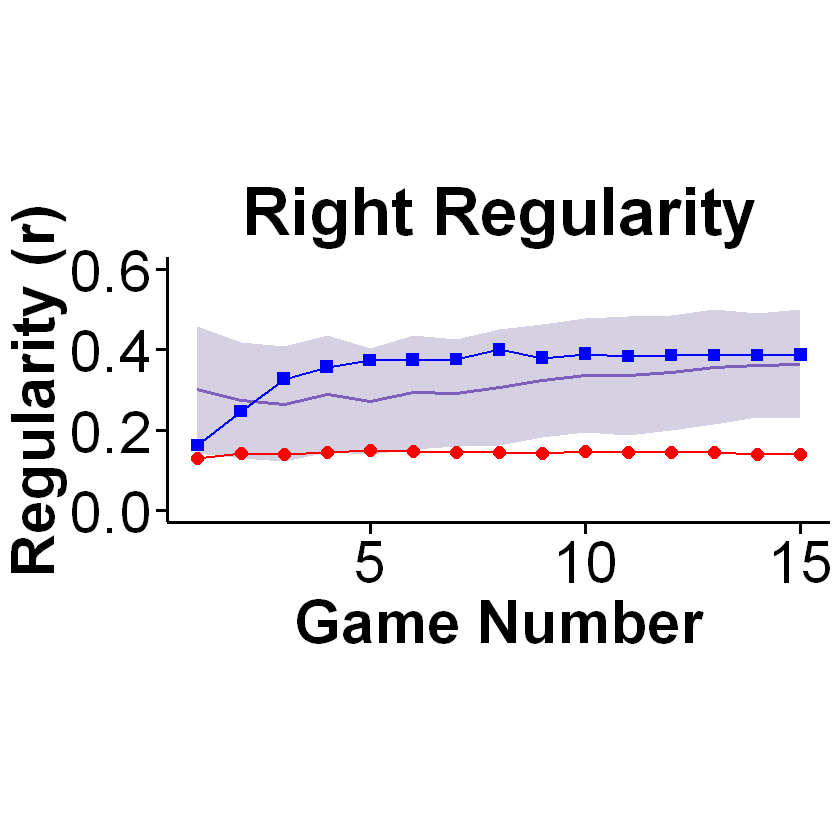

In [48]:
#Right regularity
slow_data <- data %>% filter(!Agent=='Streamed_Strategy')
#print(nrow(slow_data))
filtered_data <- slow_data %>% filter(!ShotReg=='NaN')
#print(nrow(filtered_data))
Shaded <- filtered_data %>% filter(Agent==cur_strategy)
Blending_data <- filtered_data %>% filter(Agent=='Coupled')
MS17_data <- filtered_data %>% filter(Agent=='MS17')
Hybrid_data <- filtered_data %>% filter(Agent=='Streamed')

datac2 <- summarySE(Shaded, measurevar="RightReg", groupvars=c("GameNb","Agent"),na.rm=TRUE)
datac3 <-  summarySE(Blending_data, measurevar="RightReg", groupvars=c("GameNb","Agent"),na.rm=TRUE)
datac4 <-  summarySE(MS17_data, measurevar="RightReg", groupvars=c("GameNb","Agent"),na.rm=TRUE)
datac5 <- summarySE(Hybrid_data, measurevar="RightReg", groupvars=c("GameNb","Agent"),na.rm=TRUE)

p8 <- ggplot(datac2) +  geom_line(aes(x=GameNb, y=RightReg,colour=Agent),size=1.0) + geom_ribbon(aes(x=GameNb, ymin=RightReg-sd, ymax=RightReg+sd, fill="Streamed_Strategy")) +
      theme_classic() +
      ggtitle("Right Regularity") +
      theme(plot.title = element_text(size=40,hjust=0.5,face ="bold"),
           axis.text = element_text(size = 36,color='black'),
           axis.line = element_line(colour = 'black', size = 1),
           axis.ticks = element_line(colour = "black", size = 1),
           strip.text = element_text(size = 42,face ="bold",color='black'),
           axis.title = element_text( size = 36, face = "bold" ),
           axis.ticks.length = unit(0.25, "cm"),
           legend.text = element_text( size = 40),
           legend.title = element_text( size = 40),
           legend.position = 'none', #change the legend here
           aspect.ratio=ar
          ) 
p8 <- p8+ geom_line(data = datac3, aes(x=GameNb, y=RightReg,color="Coupled"),linewidth=0.6) +
      geom_line(data = datac5, aes(x=GameNb, y=RightReg,color="Streamed"),linewidth=0.6) +
      geom_point(data = datac3, color = "blue", aes(x=GameNb, y=RightReg), shape=15,size = 3.2) +
      geom_point(data = datac5, color = "red", aes(x=GameNb, y=RightReg), shape=19,size = 3.2) +
      guides(color = guide_legend(override.aes = list(size=2))) +
      scale_fill_manual(values = alpha(c("mediumpurple4"), .25), name = "Variation (SD)") + 
      scale_color_manual(values = c("blue","mediumpurple3","red"), name = "Agent means",labels=c("Coupled Model","Slow Humans","Hybrid Model")) + 
      scale_x_continuous(name="Game Number", breaks=seq(0,15,5)) +
      scale_y_continuous(name="Regularity (r)", limits=c(0,0.6))

p8
pathFig <- './Figures_Slow/RightRegularity_lines.png'
ggsave(pathFig,p8,width=10,height=7)

In [49]:
# simple grid
gg2 <- plot_grid(p0,p1,p2,p3,p4,p5,p6,p7,p8,nrow=3)
ggsave("./Figures_Slow/Multi_LineGraphs_slow.png",gg2,width=25,height=13)